<a href="https://colab.research.google.com/github/Lior-Baruch/RL/blob/main/Mid_Project_tabular_RL_Minigrid_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - Reinforcements Learning
---
<br>

### Name and ID:
Student 1: Lior Baruch - 327156998
<br>
Student 2: Yaniv Tordjman - 204786388
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from tqdm import tqdm
import sys
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Env

In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random


class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir



        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)


        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def get_g_pos(self):
      return self.goal_pos

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        # self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        # self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))



        ## change 21-09 for random env - add player position
        # self.goal_pos = (0, 0)
        # while self.goal_pos in self.not_goal_loc:
        #   self.goal_pos = (random.randint(1, width - 2), random.randint(1, height - 2))
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])


        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place a goal square in the bottom-right corner
        # self.put_obj(Goal(), width - 2, height - 2)


        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"




# Wrappers

In [ ]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
import copy
max_env_steps = 100

class SimFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'
      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()


class KeyFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
      return self.unwrapped.goal_pos

    def get_door_pos(self):
      return self.unwrapped.door_pos

    def get_key_pos(self):
      return self.unwrapped.key_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      # map_u[self.unwrapped.width-2][self.unwrapped.height-2] = 'G'
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      if not self.is_door_open():
        door_col, door_row = self.unwrapped.door_pos
        map_up[door_row][door_col] = 'D'
        if not self.is_carrying_key():
          key_col, key_row = self.unwrapped.key_pos
          map_up[key_row][key_col] = 'K'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'

      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()

# Our code

In [ ]:
SEED = 42

# Set the seed for random number generation
random.seed(SEED)
np.random.seed(SEED)


### Utility Functions for Tabular Reinforcement Learning

This cell contains a collection of essential utility functions designed to support the implementation and evaluation of tabular reinforcement learning algorithms within MiniGrid environments. The functions include:

- **`hash_state(state)`:** Converts the environment's state into a hashable type, crucial for using states as keys in a dictionary. It handles numpy arrays by converting them into tuples and issues a playful warning if the input is not an array.
  
- **`epsilon_greedy_policy(Q, hashed_state, epsilon, num_actions, avoid_actions=[])`:** Implements the epsilon-greedy policy for action selection, balancing exploration and exploitation. It allows excluding specific actions, ensuring flexibility in navigating the state space.
  
- **`mean_list(num_list, amount_to_avg)`:** Averages elements in a list over specified intervals, useful for smoothing plots of rewards or steps to better visualize learning progress over episodes.
  
- **`display_reward_and_steps(reward_history, num_steps_history, amount_to_avg=50, figsize=(8, 3))`:** Visualizes the history of rewards and steps, averaged over specified episode intervals. It provides insights into the agent's performance and learning trends.
  
- **`display_reward_and_steps_dict(reward_history_dict, num_steps_history_dict, amount_to_avg=50, figsize=(10, 3))`:** Facilitates the comparison of agent performances under different hyperparameters by visualizing rewards and steps for each parameter set.
  
- **`plot_rewards_steps_comparison(policies, policies_reward_history, policies_num_steps_history, amount_to_avg=25, figsize=(10, 3))`:** Compares the performance of the best policies across different algorithms or settings, aiding in the selection of the most effective learning strategy.
  
- **`infer_goal(env, policy, max_steps=1000, show_init_state=False, avoid_actions=[])`:** Simulates an agent's journey towards a goal using a given policy, useful for testing policy efficacy in reaching goals within a maximum step count.
  
- **`infer_goal_with_video(env, policy, max_steps=1000, video_filename='/content/fn.mp4', avoid_actions=[])`:** Creates a video of the agent's interactions with the environment under a given policy, offering a dynamic and illustrative view of the policy in action.
  
- **`evaluate_policy(env, policy, num_episodes=100, max_steps=1000, avoid_actions=[])`:** Assesses a policy's performance by calculating average rewards, steps, and completion rates over multiple episodes.
  
- **`get_best_policy_from_policy_dict(env, policy_dict, num_episodes=100, max_steps=1000, avoid_actions=[])`:** Determines the best policy from a collection based on performance metrics, streamlining the optimization and tuning of learning algorithms.

These functions are integral to exploring, implementing, and refining reinforcement learning strategies in grid-like environments, providing a toolkit for experimentation and analysis.


In [ ]:
# Function to convert state into a hashable type
def hash_state(state):
    # if ndarray, convert to tuple
    if isinstance(state, np.ndarray):
        state = tuple(state)
    else:
        print('Warning: state is not a numpy array, bro you are in trouble (evil laugh)') # just for fun :D
    return state

# Function to implement epsilon-greedy policy
def epsilon_greedy_policy(Q, hashed_state, epsilon, num_actions, avoid_actions=[]):
    legal_actions = [i for i in range(num_actions) if i not in avoid_actions] # legal actions are those that are not in avoid_actions
    if np.random.random() < epsilon:
        action_to_take = np.random.choice(legal_actions)
    else:
        action_values = Q[hashed_state]
        action_to_take = np.argmax(action_values)
        if action_to_take in avoid_actions: # if the action to take is in avoid_actions, choose randomly from legal actions
            action_to_take = np.random.choice(legal_actions)
    return action_to_take

# Function that returns the mean value of every amount_to_avg elements in a list
def mean_list(num_list, amount_to_avg):
    # return and avarage list of every amount_to_avg elements
    avg_list = [np.mean(num_list[i:i+amount_to_avg]) for i in range(0, len(num_list), amount_to_avg)]
    return avg_list

# Function to display the reward and number of steps history
def display_reward_and_steps(reward_history, num_steps_history, amount_to_avg=50, figsize=(8, 3)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # plot the reward history
    ax1.plot(np.arange(0, len(reward_history), amount_to_avg), mean_list(reward_history, amount_to_avg))

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f"Reward History averaged over {amount_to_avg} episodes")

    # plot the number of steps history
    ax2.plot(np.arange(0, len(num_steps_history), amount_to_avg), mean_list(num_steps_history, amount_to_avg))
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Number of steps')
    ax2.set_title(f"Number of Steps History averaged over {amount_to_avg} episodes")

    plt.tight_layout()
    plt.show()

# Function to display the reward and number of steps history for each set of hyperparameters
def display_reward_and_steps_dict(reward_history_dict, num_steps_history_dict, amount_to_avg=50, figsize=(10, 3)):
    # loop over the keys in the dictionary (each key is a different set of hyperparameters)
    for key in reward_history_dict.keys(): # they have the same keys
        print(f'Hyperparameters: {key}')
        display_reward_and_steps(reward_history_dict[key], num_steps_history_dict[key], amount_to_avg, figsize)
        print('\n')

# Function to plot the reward and number of steps history for the best policies in the same plot for comparison
def plot_rewards_steps_comparison(policies, policies_reward_history, policies_num_steps_history, amount_to_avg=25, figsize=(10, 3)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    for (alg, key), policy in policies.items():
        reward_history = policies_reward_history[(alg, key)]
        num_steps_history = policies_num_steps_history[(alg, key)]
        episode_numbers = np.arange(0, len(reward_history), amount_to_avg)
        ax1.plot(episode_numbers, mean_list(reward_history, amount_to_avg), label=f"{alg} {key}")
        ax2.plot(episode_numbers, mean_list(num_steps_history, amount_to_avg), label=f"{alg} {key}")
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f"Reward History averaged over {amount_to_avg} episodes")
    ax1.legend()
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Number of steps')
    ax2.set_title(f"Number of Steps History averaged over {amount_to_avg} episodes")
    ax2.legend()
    plt.tight_layout()
    plt.show()

# Function to infer the goal with a given policy
def infer_goal(env, policy, max_steps=1000, show_init_state=False, avoid_actions=[]):
    # reset the environment
    obs = env.reset()[0]
    done = False
    total_reward = 0
    legal_actions = [i for i in range(env.action_space.n) if i not in avoid_actions]
    # show the initial state
    if show_init_state:
        screen = env.render()
        plt.imshow(screen)
    # run the environment until done or max_steps
    for step in range(max_steps):
        hashed_state = hash_state(obs)
        if hashed_state in policy:
            # get the action from the policy
            action = policy[hashed_state]
        else:
            action = np.random.choice(legal_actions)

        # take a step in the environment
        obs, reward, done, _, _ = env.step(action)
        # add the reward to the total
        total_reward += reward
        # if done, break
        if done:
            break
    # return the done flag, total reward, and number of steps
    return done, total_reward, (step+1)

# Function to infer the goal with a given policy and save a video
def infer_goal_with_video(env, policy, max_steps=1000, video_filename='/content/fn.mp4', avoid_actions=[]):
    with imageio.get_writer(video_filename, fps=10) as video:
        obs = env.reset()[0]
        done = False
        total_reward = 0
        legal_actions = [i for i in range(env.action_space.n) if i not in avoid_actions]
        # run the environment until done or max_steps
        for step in range(max_steps):
            hashed_state = hash_state(obs)
            if hashed_state in policy:
                # get the action from the policy
                action = policy[hashed_state]
            else:
                action = np.random.choice(legal_actions)
            # take a step in the environment
            obs, reward, done, _, _ = env.step(action)
            # add the reward to the total
            total_reward += reward
            video.append_data(env.render())
            # if done, break
            if done:
                break
    # return the done flag, total reward, and number of steps
    return done, total_reward, (step+1)

# Function to evaluate the policy
def evaluate_policy(env, policy, num_episodes=100, max_steps=1000, avoid_actions=[]):
    # initialize the total reward and total number of steps
    total_reward = 0
    total_steps = 0
    total_done = 0
    # loop over the episodes
    for _ in range(num_episodes):
        # infer the goal with the policy
        done, reward, steps = infer_goal(env, policy, max_steps, avoid_actions=avoid_actions)
        # add the reward and number of steps to the totals
        total_reward += reward
        total_steps += steps
        if done:
            total_done += 1
    # return the average reward and average number of steps
    avg_reward = total_reward / num_episodes
    avg_steps = total_steps / num_episodes
    avg_done = total_done / num_episodes
    return avg_reward, avg_steps, avg_done

# Function to get the best policy from a dictionary of policies
def get_best_policy_from_policy_dict(env, policy_dict, num_episodes=100, max_steps=1000, avoid_actions=[]):
    best_policy = None
    best_avg_reward = -np.inf
    best_avg_steps = np.inf
    for key, policy in policy_dict.items():
        avg_reward, avg_steps, avg_done = evaluate_policy(env, policy, num_episodes, max_steps, avoid_actions)
        if avg_reward >= best_avg_reward and avg_steps <= best_avg_steps:
            best_policy = policy
            best_avg_reward = avg_reward
            best_avg_steps = avg_steps
            best_avg_done = avg_done
            best_key = key
    return best_policy, best_avg_reward, best_avg_steps, best_avg_done, best_key

## Monte Carlo Implementation

This section introduces the core mechanics behind Monte Carlo Control using the epsilon-greedy policy for decision-making in a reinforcement learning environment. The presented functions collectively form an algorithm to estimate the optimal policy and value function for a given environment. Key components include:

- **`generate_episode`:** This function simulates an episode within the environment, following an epsilon-greedy policy. It optionally incorporates reward shaping based on environmental changes (e.g., door states) to encourage specific behaviors.

- **`update_Q`:** After generating an episode, this function updates the Q-table (action-value function) based on the returns (cumulative discounted rewards) of each state-action pair encountered. It employs a first-visit Monte Carlo approach, updating values only for the first occurrence of each state-action pair in an episode.

- **`mc_control_epsilon_greedy`:** The main driver function orchestrates the Monte Carlo Control algorithm. It iteratively generates episodes, updates the Q-table, and adjusts the exploration rate (epsilon) to balance exploration and exploitation over time. The function tracks the history of rewards and steps per episode, providing insights into the learning process and the effectiveness of the policy.

Parameters such as `num_episodes`, `epsilon`, `gamma` (discount factor), `max_env_steps`, `epsilon_decay`, and optional reward shaping are configurable, allowing for flexible adaptation to different environments and learning goals.

In [ ]:
import sys
from collections import defaultdict

# Function to generate an episode following the epsilon-greedy policy
def generate_episode(env, Q, epsilon, max_steps, avoid_actions=[], reward_shaping=False):
    # initialize the episode list, reset the environment, and get the initial state and hashed state
    episode = []
    state = env.reset()[0]
    hashed_state = hash_state(state)
    # loop over the max_steps
    for t in range(max_steps):
        # get info before action
        prev_is_door_open = env.is_door_open()
        # get the action following the epsilon-greedy policy and take a step in the environment
        action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n, avoid_actions)
        next_state, reward, done, _, _ = env.step(action)
        # get info after action
        is_door_open = env.is_door_open()
        # reward shaping
        if reward_shaping:
            if not prev_is_door_open and is_door_open:
                reward += 0.001
            if prev_is_door_open and not is_door_open:
                reward -= 0.001

        # append the state, action, and reward to the episode
        episode.append((hashed_state, action, reward))
        if done:
            break
        # update the current state and hashed state
        state = next_state
        hashed_state = hash_state(state)
    return episode, done

# Function to update the Q-table based on the generated episode
def update_Q(episode, Q, returns_sum, state_action_count, gamma):
    # get the states, actions, and rewards in the episode
    states, actions, rewards = zip(*episode)
    num_of_steps = len(rewards) + 1
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(num_of_steps)])
    # update the sum of the returns, and the count of returns for each state-action pair in the episode
    for i, (state , action) in enumerate(zip(states, actions)):
        # calculate i_th discounted return
        i_discounted_rewards = rewards[i:] * discounts[:-(1 + i)]
        # update the sum of the returns
        returns_sum[state][action] += sum(i_discounted_rewards)
        # update the count of returns
        state_action_count[state][action] += 1.0
        # update the Q-table
        Q[state][action] = returns_sum[state][action] / state_action_count[state][action]
    return Q

# Main function to implement the Monte Carlo Control with Epsilon-Greedy policy
def mc_control_epsilon_greedy(env, num_episodes, epsilon, gamma=1.0, max_env_steps=1000,
                               print_every=100, epsilon_decay=1.0, avoid_actions=[], reward_shaping=False):
    """
    Params:
        env: the environment
        num_episodes: number of episodes to run the algorithm
        epsilon: the probability to select a random action instead of the greedy action
        gamma: the discount factor
        max_env_steps: the maximum number of steps in the environment
        print_every: print the total reward and number of steps every 'print_every' episodes
        epsilon_decay: the decay rate of epsilon
        avoid_actions: list of actions to avoid
        reward_shaping: flag to use reward shaping
    Returns:
        policy: the optimal policy
        Q: the Q-table
        reward_history: the history of the total reward in each episode
        num_steps_history: the history of the number of steps in each episode
    """
    # init history
    reward_history = []
    num_steps_history = []
    done_history = []
    # initialize the Q-table, returns sum, and state-action count
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_count = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over the episodes
    for i in tqdm(range(num_episodes)):
        # generate an episode and update the Q-table
        episode, done = generate_episode(env, Q, epsilon, max_env_steps, avoid_actions, reward_shaping)
        Q = update_Q(episode, Q, returns_sum, state_action_count, gamma)
        # Calculate total reward for the episode and append into the reward_history list
        curr_reward = sum([reward for _, _, reward in episode])
        # append the total reward, number of steps, and done flag to the history lists
        reward_history.append(curr_reward)
        num_steps_history.append(len(episode))
        done_history.append(done)

        # Print out the total reward and number of steps in the episode every 'print_every' episodes
        if i % print_every == 0 or i == num_episodes - 1:
            print(f"\rEpisode {i}/{num_episodes}. avg done: {format(np.mean(done_history[-print_every:]), '.3f')}, Avg reward: {format(np.mean(reward_history[-print_every:]), '.3f')}, Avg steps: {format(np.mean(num_steps_history[-print_every:]), '.3f')}, epsilon: {format(epsilon, '.3f')}", end="")
            sys.stdout.flush()
        # decay epsilon
        epsilon *= epsilon_decay

    # get the policy from the Q-table (for each state, get the action with the highest value)
    policy = {state: np.argmax(values) for state, values in Q.items()}
    # return the policy, Q-table, and the reward history
    return policy, Q, reward_history, num_steps_history

## SARSA (State-Action-Reward-State-Action) Implementation

This function encapsulates the SARSA algorithm, a foundational method in reinforcement learning that uses Temporal Difference (TD) learning to iteratively estimate the Q-values (action-value function) for state-action pairs. SARSA is an on-policy algorithm, meaning it evaluates and improves the same policy used to make decisions. The algorithm details are as follows:

- **Parameters:**
    - `env`: The environment in which the agent operates.
    - `num_episodes`: The total number of episodes for training.
    - `epsilon`: Exploration rate for the epsilon-greedy policy, controlling the trade-off between exploration and exploitation.
    - `alpha`: The learning rate, determining the extent to which new information overrides old information.
    - `gamma`: The discount factor, representing the importance of future rewards.
    - `max_env_steps`: The maximum number of steps per episode.
    - `print_every`: Frequency of feedback on the algorithm's performance.
    - `epsilon_decay`: Rate at which epsilon is decreased, reducing the amount of exploration over time.
    - `avoid_actions`: A list of actions the agent should avoid, if applicable.
    - `reward_shaping`: A flag indicating whether to apply reward shaping for encouraging specific behaviors.

- **Process:**
    The function iterates over episodes, each beginning with a fresh environment state. At each step within an episode:
    1. An action is selected using the epsilon-greedy policy based on the current state.
    2. The agent executes the action, and the environment returns the next state and reward.
    3. Reward shaping may adjust the received reward based on predefined criteria (e.g., opening or closing doors).
    4. The next action is chosen using the epsilon-greedy policy from the new state.
    5. The Q-value for the current state-action pair is updated using the SARSA update rule, which incorporates the reward received and the estimated value of the next state-action pair.

- **Learning Outcome:**
    The algorithm updates the Q-table after each step, refining the policy towards optimality. It returns the optimal policy, the Q-table, and histories of rewards and steps per episode for analysis.

- **Usage Note:**
    This function is suitable for discrete action spaces and environments where the agent's decisions directly influence its subsequent state. It's particularly useful for problems requiring a balance between exploration of the environment and exploitation of known rewards.


In [ ]:
# Function to implement the SARSA algorithm
def sarsa(env, num_episodes, epsilon, alpha, gamma=1.0, max_env_steps=1000,
           print_every=100, epsilon_decay=1.0, avoid_actions=[], reward_shaping=False):
    """
    Params:
        env: the environment
        num_episodes: number of episodes to run the algorithm
        epsilon: the probability to select a random action instead of the greedy action
        alpha: the learning rate
        gamma: the discount factor
        max_env_steps: the maximum number of steps in the environment
        print_every: print the total reward and number of steps every 'print_every' episodes
        epsilon_decay: the decay rate of epsilon
        avoid_actions: list of actions to avoid
        reward_shaping: flag to use reward shaping
    Returns:
        policy: the optimal policy
        Q: the Q-table
        reward_history: the history of the total reward in each episode
        num_steps_history: the history of the number of steps in each episode
    """
    # init history and Q-table
    reward_history = []
    num_steps_history = []
    done_history = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i in tqdm(range(num_episodes)):
        # reset the environment
        state = env.reset()[0]
        # get the hashed state
        hashed_state = hash_state(state)
        # get the action from the epsilon-greedy policy
        action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n,
                                        avoid_actions=avoid_actions)
        done = False
        total_reward = 0
        # loop over steps
        for t in range(max_env_steps):
            # get info before action
            prev_is_door_open = env.is_door_open()
            # take a step in the environment
            next_state, reward, done, _, _ = env.step(action)
            # get info after action
            curr_is_door_open = env.is_door_open()

            # reward shaping
            if reward_shaping:
                if not prev_is_door_open and curr_is_door_open:
                    reward += 0.001
                if prev_is_door_open and not curr_is_door_open:
                    reward -= 0.001

            # add the reward to the total
            total_reward += reward
            # get the next hashed state
            next_hashed_state = hash_state(next_state)
            # get the next action from the epsilon-greedy policy
            next_action = epsilon_greedy_policy(Q, next_hashed_state, epsilon, env.action_space.n, avoid_actions=avoid_actions)
            # update the Q-table
            td_target = reward + gamma * Q[next_hashed_state][next_action] # curr target
            td_delta = td_target - Q[hashed_state][action] # curr delta
            Q[hashed_state][action] += alpha * td_delta # update
            # update the state and action
            state = next_state
            hashed_state = next_hashed_state
            action = next_action
            # if done, break
            if done:
                break
        # append the total reward to the reward history
        reward_history.append(total_reward)
        num_steps_history.append(t)
        done_history.append(done)
        # Print out the total reward every 100 episodes
        if i % print_every == 0 or i == num_episodes - 1:
            print(f"\rEpisode {i}/{num_episodes}. avg done: {format(np.mean(done_history[-print_every:]), '.3f')}, Avg reward: {format(np.mean(reward_history[-print_every:]), '.3f')}, Avg steps: {format(np.mean(num_steps_history[-print_every:]), '.3f')}, epsilon: {format(epsilon, '.3f')}", end="")
            sys.stdout.flush()
        # decay epsilon
        epsilon *= epsilon_decay

    # return the Q-table and the reward history
    policy = {state: np.argmax(values) for state, values in Q.items()}
    return policy, Q, reward_history, num_steps_history


## Q-Learning Algorithm Implementation

This cell details the implementation of the Q-Learning algorithm, an off-policy TD (Temporal Difference) learning strategy used for finding the optimal action-value function in a reinforcement learning setting. Unlike SARSA, Q-Learning determines the next action by choosing the maximum future reward achievable from the next state, regardless of the policy being followed. Key components include:

- **Parameters:**
    - `env`: The environment in which the agent operates, offering states, actions, and rewards.
    - `num_episodes`: Total episodes for the agent to learn from.
    - `epsilon`: Initial exploration rate, governing the balance between exploration and exploitation.
    - `alpha`: Learning rate, influencing the rate at which new information affects learned values.
    - `gamma`: Discount factor, denoting the importance of future rewards.
    - `max_env_steps`: Cap on steps per episode, preventing infinite loops.
    - `print_every`: Frequency of progress updates during training.
    - `epsilon_decay`: Rate of decay for epsilon, reducing exploration over time.
    - `avoid_actions`: Actions to be avoided by the agent, if any.
    - `reward_shaping`: Optional modification of rewards based on desired behaviors.

- **Process:**
    Same as SARSA, the Q-Learning algorithm iterates over episodes, updating the Q-table based on the agent's interactions with the environment. However, Q-Learning selects the next action based on the maximum Q-value of the next state, regardless of the policy being followed. This off-policy nature allows Q-Learning to directly approximate the optimal policy while exploring the environment.

- **Outcome:**
    The result is an optimal policy that maximizes the cumulative reward the agent can expect to receive, starting from any given state. The function also tracks the total reward and number of steps per episode, allowing for performance evaluation over time.

In [ ]:
# Function to implement the Q-learning algorithm (like SARSA but with max over next state-action pairs)
def q_learning(env, num_episodes, epsilon, alpha, gamma=1.0, max_env_steps=1000,
                    print_every=100, epsilon_decay=0.999, avoid_actions=[],reward_shaping=False):
    """
    Params:
        env: the environment
        num_episodes: number of episodes to run the algorithm
        epsilon: the probability to select a random action instead of the greedy action
        alpha: the learning rate
        gamma: the discount factor
        max_env_steps: the maximum number of steps in the environment
        print_every: print the total reward and number of steps every 'print_every' episodes
        epsilon_decay: the decay rate of epsilon
        avoid_actions: list of actions to avoid
        reward_shaping: flag to use reward shaping
    Returns:
        policy: the optimal policy
        Q: the Q-table
        reward_history: the history of the total reward in each episode
        num_steps_history: the history of the number of steps in each episode
    """
    # init history and Q-table
    reward_history = []
    num_steps_history = []
    done_history = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i in tqdm(range(num_episodes)):
        # reset the environment
        state = env.reset()[0]
        # get the hashed state
        hashed_state = hash_state(state)
        done = False
        total_reward = 0
        # loop over steps
        for t in range(max_env_steps):
            # get info before action for reward shaping
            prev_is_door_open = env.is_door_open()

           # get the action from the epsilon-greedy policy (avoid actions)
            action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n, avoid_actions=avoid_actions)
            # take a step in the environment
            next_state, reward, done, _, _ = env.step(action)

            # get info after action for reward shaping
            curr_is_door_open = env.is_door_open()

            # reward shaping
            if reward_shaping:
                if not prev_is_door_open and curr_is_door_open:
                    reward += 0.001
                if prev_is_door_open and not curr_is_door_open:
                    reward += -0.001

            # add the reward to the total
            total_reward += reward
            # get the next hashed state
            next_hashed_state = hash_state(next_state)
            # update the Q-table
            best_next_action = np.argmax(Q[next_hashed_state]) # best action
            td_target = reward + gamma * Q[next_hashed_state][best_next_action] # curr target
            td_delta = td_target - Q[hashed_state][action] # curr delta
            Q[hashed_state][action] += alpha * td_delta # update
            # update the state
            state = next_state
            hashed_state = next_hashed_state
            # if done, break
            if done:
                break
        # append the total reward to the reward history
        reward_history.append(total_reward)
        num_steps_history.append(t)
        done_history.append(done)
        # Print out the total reward every 100 episodes
        if i % print_every == 0 or i == num_episodes - 1:
            print(f"\rEpisode {i}/{num_episodes}. avg done: {format(np.mean(done_history[-print_every:]), '.3f')}, Avg reward: {format(np.mean(reward_history[-print_every:]), '.3f')}, Avg steps: {format(np.mean(num_steps_history[-print_every:]), '.3f')}, epsilon: {format(epsilon, '.3f')}", end="")
            sys.stdout.flush()
        # decay epsilon after each episode
        epsilon *= epsilon_decay

    # return the Q-table and the reward history
    policy = {state: np.argmax(values) for state, values in Q.items()}
    return policy, Q, reward_history, num_steps_history

## Grid Search for Optimal Hyperparameters in Monte Carlo and TD Learning

These functions, `grid_search_mc` and `grid_search_TD`, implement a comprehensive search over specified hyperparameters to identify the optimal settings for Monte Carlo Control and Temporal Difference (TD) learning algorithms (SARSA and Q-Learning) within a given environment. The grid search explores combinations of `epsilon` (exploration rate), `gamma` (discount factor), and `alpha` (learning rate for TD learning) to optimize the learning process.

- **Key Features:**
    - **Monte Carlo Grid Search (`grid_search_mc`):** Focuses on finding the best `epsilon` and `gamma` values for the Monte Carlo method, running the `mc_control_epsilon_greedy` function across different settings.
    - **TD Learning Grid Search (`grid_search_TD`):** Expands the search to include `alpha` for SARSA and Q-Learning algorithms, determining the most effective combination of exploration, learning rate, and discounting for future rewards.

- **Parameters:**
    Include the environment (`env`), number of episodes (`num_episodes`), step limit (`max_steps`), exploration rates (`epsilons`), discount factors (`gammas`), learning rates (`alphas`), and additional controls like `epsilon_decay`, `print_every`, `avoid_actions`, and `reward_shaping`.

- **Process:**
    Each function iterates over the specified ranges of hyperparameters, training the relevant RL algorithm with each combination and tracking the resulting policy, Q-values, and episode metrics (rewards and steps). This systematic approach allows for an empirical evaluation of how different settings impact learning effectiveness and efficiency.

- **Outcomes:**
    The functions return dictionaries mapping hyperparameter settings to the learned policies, Q-tables, reward histories, and step histories. These outputs enable a detailed analysis of the impact of each hyperparameter on the learning outcome, guiding the selection of the best overall strategy for the task at hand.

In [ ]:
# monte carlo grid search for empty env
def grid_search_mc(env, num_episodes=100, max_steps=1000, epsilons=[1], gammas=[0.99],
                    epsilon_decay=0.999, print_every=500, avoid_actions=[], reward_shaping=False):
    # initialize the history
    policy_dict = {}
    Q_dict = {}
    reward_history_dict = {}
    num_steps_history_dict = {}


    # loop over the hyperparameters
    for epsilon in epsilons:
        for gamma in gammas:
            print(f"Training for epsilon={epsilon}, gamma={gamma}")
            policy, Q, reward_history, num_steps_history = mc_control_epsilon_greedy(env, num_episodes, epsilon, gamma, max_steps, epsilon_decay=epsilon_decay,
                                                                                      print_every=print_every, avoid_actions=avoid_actions, reward_shaping=reward_shaping)
            print(f"\nDone training for epsilon={epsilon}, gamma={gamma}\n")
            # store the policy, Q-table, reward history, and number of steps history
            policy_dict[(epsilon, gamma)] = policy
            Q_dict[(epsilon, gamma)] = Q
            reward_history_dict[(epsilon, gamma)] = reward_history
            num_steps_history_dict[(epsilon, gamma)] = num_steps_history
    # return the dictionaries for user to explore the results and choose the best policy
    return policy_dict, Q_dict, reward_history_dict, num_steps_history_dict

# sarsa and q-learning grid search for empty env
def grid_search_TD(env, num_episodes=100, max_steps=1000, epsilons=[1], gammas=[0.99], alphas=[0.1], type='sarsa',
                    epsilon_decay=0.999, print_every=500, avoid_actions=[], reward_shaping=False):
    # initialize the history
    policy_dict = {}
    Q_dict = {}
    reward_history_dict = {}
    num_steps_history_dict = {}


    # loop over the hyperparameters
    for epsilon in epsilons:
        for gamma in gammas:
            for alpha in alphas:
                print(f"Training for epsilon={epsilon}, gamma={gamma}, alpha={alpha}")
                if type == 'sarsa':
                    policy, Q, reward_history, num_steps_history = sarsa(env, num_episodes, epsilon, alpha, gamma, max_steps,
                                                                          epsilon_decay=epsilon_decay, print_every=print_every, avoid_actions=avoid_actions, reward_shaping=reward_shaping)
                else:
                    policy, Q, reward_history, num_steps_history = q_learning(env, num_episodes, epsilon, alpha, gamma, max_steps,
                                                                               epsilon_decay=epsilon_decay, print_every=print_every, avoid_actions=avoid_actions, reward_shaping=reward_shaping)
                print(f"\nDone training for epsilon={epsilon}, gamma={gamma}, alpha={alpha}\n")
                # store the policy, Q-table, reward history, and number of steps history
                policy_dict[(epsilon, gamma, alpha)] = policy
                Q_dict[(epsilon, gamma, alpha)] = Q
                reward_history_dict[(epsilon, gamma, alpha)] = reward_history
                num_steps_history_dict[(epsilon, gamma, alpha)] = num_steps_history
    # return the dictionaries for user to explore the results and choose the best policy
    return policy_dict, Q_dict, reward_history_dict, num_steps_history_dict


## Performe grid search on Empty Environment

- define hyperparameters
- perform grid search on empty environment for each algorithm
- plot the results
- choose the best hyperparameters for each algorithm
- show inference on the best policy for each algorithm
- compare best policies for each algorithm and choose the best one

- define hyperparameters

In [ ]:
# Define hyperparameters for MC, SARSA and Q-learning grid search
num_episodes = 1000
max_steps = 1000
epsilons = [0.5, 1]
gammas = [0.9, 0.99]
alphas = [0.1, 0.2]
epsilon_decay = 0.999
print_every = int(num_episodes / 2)

# Initialize the environment
empty_env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))

- perform grid search on empty environment for each algorithm

In [ ]:
# Perform the grid search for MC on the empty environment
print("Monte Carlo Control")
policy_dict_mc_empty, Q_dict_mc_empty, reward_history_dict_mc_empty, num_steps_history_dict_mc_empty = grid_search_mc(
    empty_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=[],
    reward_shaping=False
)

# Perform the grid search for SARSA on the empty environment
print("\nSARSA")
policy_dict_sarsa_empty, Q_dict_sarsa_empty, reward_history_dict_sarsa_empty, num_steps_history_dict_sarsa_empty = grid_search_TD(
    empty_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='sarsa',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=[],
    reward_shaping=False
)

# Perform the grid search for Q-learning on the empty environment
print("\nQ-learning")
policy_dict_q_learning_empty, Q_dict_q_learning_empty, reward_history_dict_q_learning_empty, num_steps_history_dict_q_learning_empty = grid_search_TD(
    empty_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='q_learning',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=[],
    reward_shaping=False
)



Monte Carlo Control
Training for epsilon=0.5, gamma=0.9


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 0.000, Avg reward: 0.000, Avg steps: 1000.000, epsilon: 0.500

 50%|████▉     | 497/1000 [00:31<00:07, 70.65it/s]

Episode 500/1000. avg done: 0.988, Avg reward: 0.988, Avg steps: 57.466, epsilon: 0.303

 99%|█████████▊| 987/1000 [00:38<00:00, 98.41it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 18.020, epsilon: 0.184

100%|██████████| 1000/1000 [00:38<00:00, 26.17it/s] 



Done training for epsilon=0.5, gamma=0.9

Training for epsilon=0.5, gamma=0.99


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 650.000, epsilon: 0.500

 50%|████▉     | 497/1000 [00:24<00:11, 42.58it/s]

Episode 500/1000. avg done: 0.994, Avg reward: 0.994, Avg steps: 71.208, epsilon: 0.303

100%|█████████▉| 999/1000 [00:35<00:00, 52.71it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 31.646, epsilon: 0.184

100%|██████████| 1000/1000 [00:35<00:00, 28.20it/s]



Done training for epsilon=0.5, gamma=0.99

Training for epsilon=1, gamma=0.9


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 78.000, epsilon: 1.000

 50%|█████     | 500/1000 [00:44<00:10, 47.19it/s]

Episode 500/1000. avg done: 0.984, Avg reward: 0.984, Avg steps: 131.540, epsilon: 0.606

100%|█████████▉| 998/1000 [00:52<00:00, 91.01it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 24.326, epsilon: 0.368

100%|██████████| 1000/1000 [00:52<00:00, 18.97it/s]



Done training for epsilon=1, gamma=0.9

Training for epsilon=1, gamma=0.99


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 242.000, epsilon: 1.000

 50%|████▉     | 497/1000 [00:53<00:14, 34.96it/s]

Episode 500/1000. avg done: 0.978, Avg reward: 0.978, Avg steps: 159.676, epsilon: 0.606

 99%|█████████▉| 992/1000 [01:05<00:00, 48.52it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 32.628, epsilon: 0.368

100%|██████████| 1000/1000 [01:05<00:00, 15.16it/s]



Done training for epsilon=1, gamma=0.99


SARSA
Training for epsilon=0.5, gamma=0.9, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 221.000, epsilon: 0.500

 50%|████▉     | 498/1000 [00:41<00:05, 83.67it/s]

Episode 500/1000. avg done: 0.966, Avg reward: 0.966, Avg steps: 131.770, epsilon: 0.303

100%|█████████▉| 996/1000 [00:47<00:00, 117.72it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 15.744, epsilon: 0.184

100%|██████████| 1000/1000 [00:47<00:00, 21.07it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.1

Training for epsilon=0.5, gamma=0.9, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 0.000, Avg reward: 0.000, Avg steps: 999.000, epsilon: 0.500

 50%|████▉     | 498/1000 [00:43<00:05, 85.75it/s]

Episode 500/1000. avg done: 0.946, Avg reward: 0.946, Avg steps: 150.912, epsilon: 0.303

100%|█████████▉| 996/1000 [00:50<00:00, 115.90it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 18.336, epsilon: 0.184

100%|██████████| 1000/1000 [00:50<00:00, 19.89it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.2

Training for epsilon=0.5, gamma=0.99, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 0.000, Avg reward: 0.000, Avg steps: 999.000, epsilon: 0.500

 50%|████▉     | 495/1000 [00:39<00:05, 89.70it/s]

Episode 500/1000. avg done: 0.964, Avg reward: 0.964, Avg steps: 126.922, epsilon: 0.303

 99%|█████████▉| 992/1000 [00:44<00:00, 119.66it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 17.188, epsilon: 0.184

100%|██████████| 1000/1000 [00:44<00:00, 22.65it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.1

Training for epsilon=0.5, gamma=0.99, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 811.000, epsilon: 0.500

 49%|████▉     | 491/1000 [00:37<00:05, 90.18it/s]

Episode 500/1000. avg done: 0.962, Avg reward: 0.962, Avg steps: 122.022, epsilon: 0.303

 99%|█████████▉| 992/1000 [00:43<00:00, 109.66it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 17.418, epsilon: 0.184

100%|██████████| 1000/1000 [00:43<00:00, 22.88it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.2

Training for epsilon=1, gamma=0.9, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 340.000, epsilon: 1.000

 50%|█████     | 500/1000 [00:42<00:08, 60.87it/s]

Episode 500/1000. avg done: 0.988, Avg reward: 0.988, Avg steps: 127.286, epsilon: 0.606

 99%|█████████▉| 990/1000 [00:49<00:00, 103.31it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 19.962, epsilon: 0.368

100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.1

Training for epsilon=1, gamma=0.9, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 444.000, epsilon: 1.000

 49%|████▉     | 494/1000 [00:41<00:08, 61.66it/s]

Episode 500/1000. avg done: 0.980, Avg reward: 0.980, Avg steps: 133.664, epsilon: 0.606

100%|█████████▉| 996/1000 [00:47<00:00, 99.82it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 21.758, epsilon: 0.368

100%|██████████| 1000/1000 [00:47<00:00, 21.06it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.2

Training for epsilon=1, gamma=0.99, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 280.000, epsilon: 1.000

 50%|████▉     | 497/1000 [00:39<00:17, 29.11it/s]

Episode 500/1000. avg done: 0.974, Avg reward: 0.974, Avg steps: 132.626, epsilon: 0.606

 99%|█████████▉| 993/1000 [00:47<00:00, 99.20it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 21.906, epsilon: 0.368

100%|██████████| 1000/1000 [00:47<00:00, 20.88it/s]



Done training for epsilon=1, gamma=0.99, alpha=0.1

Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 885.000, epsilon: 1.000

 50%|█████     | 500/1000 [00:41<00:09, 52.33it/s]

Episode 500/1000. avg done: 0.980, Avg reward: 0.980, Avg steps: 131.342, epsilon: 0.606

 99%|█████████▉| 988/1000 [00:48<00:00, 94.87it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 20.430, epsilon: 0.368

100%|██████████| 1000/1000 [00:48<00:00, 20.69it/s] 



Done training for epsilon=1, gamma=0.99, alpha=0.2


Q-learning
Training for epsilon=0.5, gamma=0.9, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 0.000, Avg reward: 0.000, Avg steps: 999.000, epsilon: 0.500

 50%|████▉     | 496/1000 [00:32<00:12, 40.42it/s]

Episode 500/1000. avg done: 0.968, Avg reward: 0.968, Avg steps: 102.632, epsilon: 0.303

100%|█████████▉| 999/1000 [00:38<00:00, 115.15it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 17.638, epsilon: 0.184

100%|██████████| 1000/1000 [00:38<00:00, 26.00it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.1

Training for epsilon=0.5, gamma=0.9, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 328.000, epsilon: 0.500

 50%|████▉     | 497/1000 [00:32<00:08, 59.95it/s]

Episode 500/1000. avg done: 0.976, Avg reward: 0.976, Avg steps: 106.622, epsilon: 0.303

100%|█████████▉| 997/1000 [00:37<00:00, 123.99it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 15.412, epsilon: 0.184

100%|██████████| 1000/1000 [00:37<00:00, 26.69it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.2

Training for epsilon=0.5, gamma=0.99, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 349.000, epsilon: 0.500

 50%|████▉     | 499/1000 [00:30<00:05, 97.08it/s]

Episode 500/1000. avg done: 0.972, Avg reward: 0.972, Avg steps: 104.170, epsilon: 0.303

 99%|█████████▉| 991/1000 [00:36<00:00, 105.65it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 15.742, epsilon: 0.184

100%|██████████| 1000/1000 [00:36<00:00, 27.40it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.1

Training for epsilon=0.5, gamma=0.99, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 0.000, Avg reward: 0.000, Avg steps: 999.000, epsilon: 0.500

 50%|█████     | 500/1000 [00:38<00:06, 77.42it/s]

Episode 500/1000. avg done: 0.966, Avg reward: 0.966, Avg steps: 121.044, epsilon: 0.303

 99%|█████████▉| 992/1000 [00:43<00:00, 114.60it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 17.678, epsilon: 0.184

100%|██████████| 1000/1000 [00:43<00:00, 22.97it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.2

Training for epsilon=1, gamma=0.9, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 895.000, epsilon: 1.000

 50%|████▉     | 497/1000 [00:35<00:10, 48.19it/s]

Episode 500/1000. avg done: 0.990, Avg reward: 0.990, Avg steps: 114.688, epsilon: 0.606

 99%|█████████▉| 992/1000 [00:43<00:00, 64.96it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 20.544, epsilon: 0.368

100%|██████████| 1000/1000 [00:43<00:00, 23.16it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.1

Training for epsilon=1, gamma=0.9, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 0.000, Avg reward: 0.000, Avg steps: 999.000, epsilon: 1.000

 49%|████▉     | 494/1000 [00:33<00:08, 58.35it/s]

Episode 500/1000. avg done: 0.986, Avg reward: 0.986, Avg steps: 111.408, epsilon: 0.606

100%|█████████▉| 998/1000 [00:41<00:00, 98.28it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 22.102, epsilon: 0.368

100%|██████████| 1000/1000 [00:41<00:00, 23.97it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.2

Training for epsilon=1, gamma=0.99, alpha=0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 122.000, epsilon: 1.000

 50%|████▉     | 497/1000 [00:35<00:10, 47.00it/s]

Episode 500/1000. avg done: 0.980, Avg reward: 0.980, Avg steps: 117.062, epsilon: 0.606

 99%|█████████▉| 993/1000 [00:43<00:00, 114.08it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 21.170, epsilon: 0.368

100%|██████████| 1000/1000 [00:43<00:00, 22.90it/s]



Done training for epsilon=1, gamma=0.99, alpha=0.1

Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 404.000, epsilon: 1.000

 50%|████▉     | 498/1000 [00:34<00:07, 67.37it/s]

Episode 500/1000. avg done: 0.992, Avg reward: 0.992, Avg steps: 112.060, epsilon: 0.606

 99%|█████████▉| 990/1000 [00:42<00:00, 93.14it/s]

Episode 999/1000. avg done: 1.000, Avg reward: 1.000, Avg steps: 21.598, epsilon: 0.368

100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s]



Done training for epsilon=1, gamma=0.99, alpha=0.2



- plot the results

Monte Carlo on Empty Env


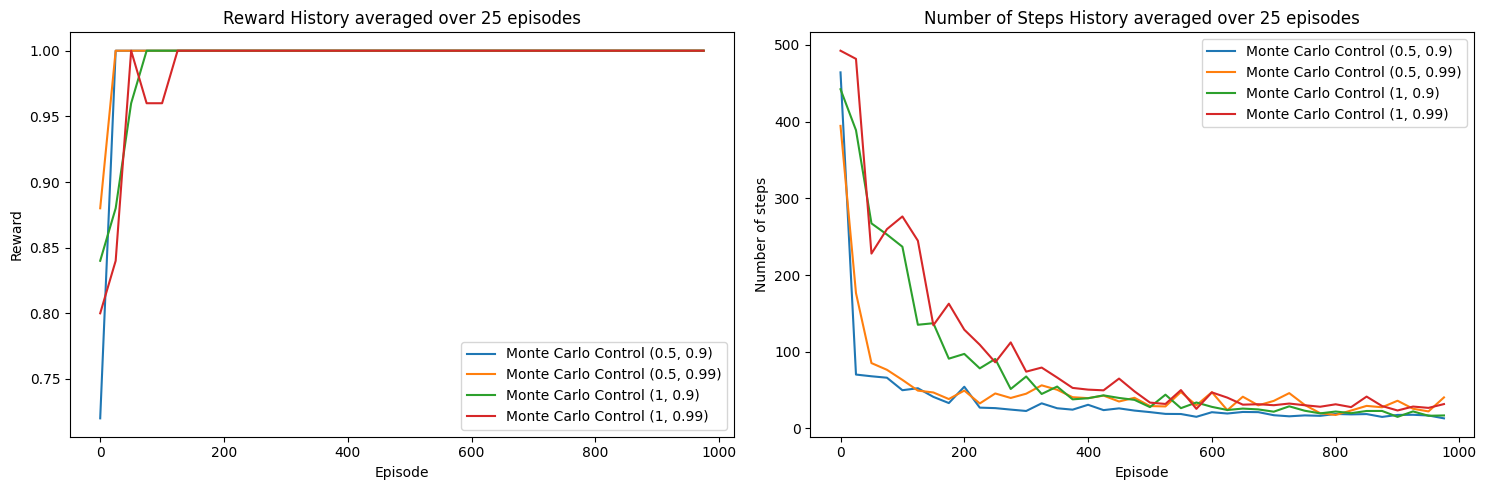


SARSA on Empty Env


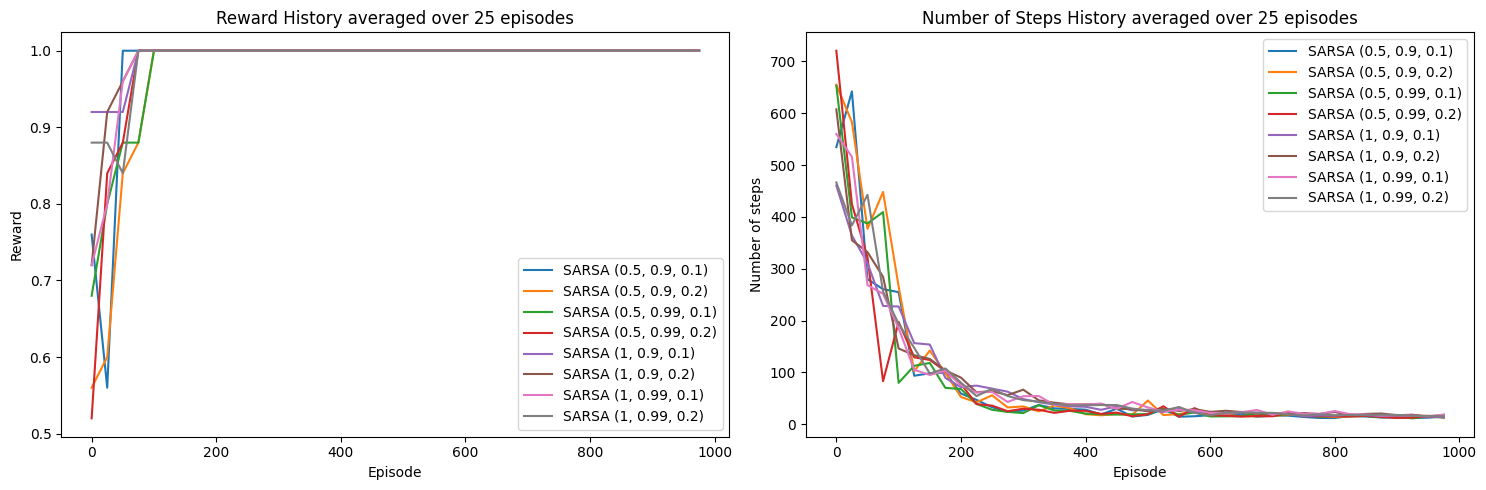


Q-learning on Empty Env


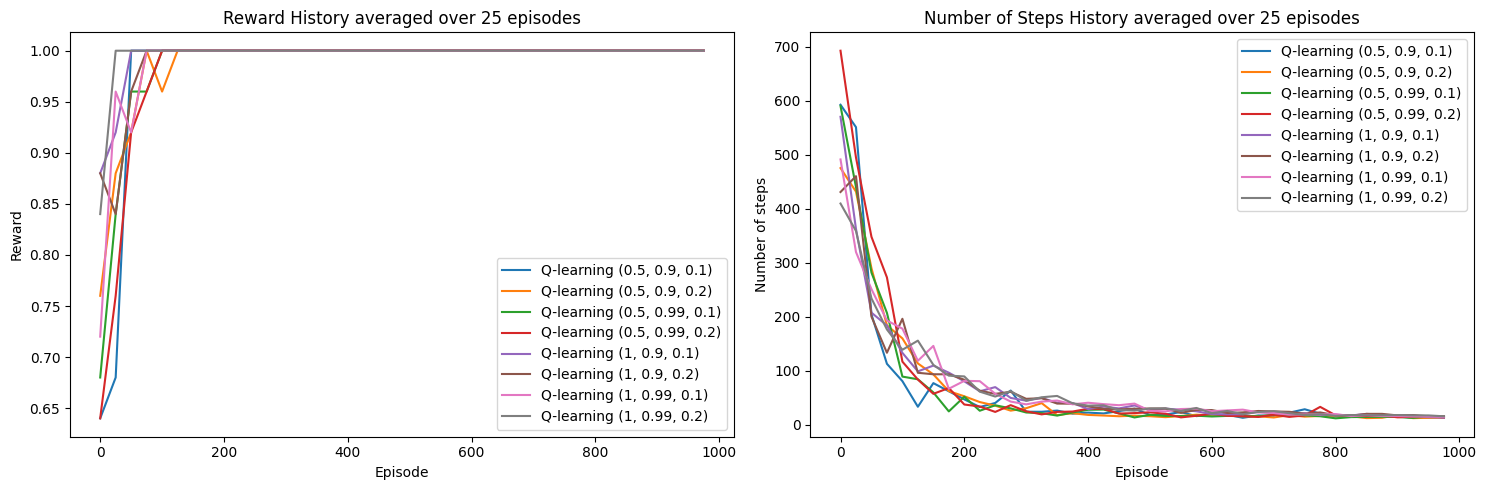

In [ ]:
# Plot for each algo the reward and number of steps history for each hyperparameter set
algo_mc_dict_empty = {('Monte Carlo Control', key): value for key, value in policy_dict_mc_empty.items()}
algo_sarsa_dict_empty = {('SARSA', key): value for key, value in policy_dict_sarsa_empty.items()}
algo_q_learning_dict_empty = {('Q-learning', key): value for key, value in policy_dict_q_learning_empty.items()}

algo_mc_reward_history_dict_empty = {('Monte Carlo Control', key): value for key, value in reward_history_dict_mc_empty.items()}
algo_sarsa_reward_history_dict_empty = {('SARSA', key): value for key, value in reward_history_dict_sarsa_empty.items()}
algo_q_learning_reward_history_dict_empty = {('Q-learning', key): value for key, value in reward_history_dict_q_learning_empty.items()}

algo_mc_num_steps_history_dict_empty = {('Monte Carlo Control', key): value for key, value in num_steps_history_dict_mc_empty.items()}
algo_sarsa_num_steps_history_dict_empty = {('SARSA', key): value for key, value in num_steps_history_dict_sarsa_empty.items()}
algo_q_learning_num_steps_history_dict_empty = {('Q-learning', key): value for key, value in num_steps_history_dict_q_learning_empty.items()}

figsize = (15, 5)
amount_to_avg = 25

print("Monte Carlo on Empty Env")
plot_rewards_steps_comparison(policies=algo_mc_dict_empty, policies_reward_history=algo_mc_reward_history_dict_empty, policies_num_steps_history=algo_mc_num_steps_history_dict_empty, amount_to_avg=amount_to_avg, figsize=figsize)

print("\nSARSA on Empty Env")
plot_rewards_steps_comparison(policies=algo_sarsa_dict_empty, policies_reward_history=algo_sarsa_reward_history_dict_empty, policies_num_steps_history=algo_sarsa_num_steps_history_dict_empty, amount_to_avg=amount_to_avg, figsize=figsize)

print("\nQ-learning on Empty Env")
plot_rewards_steps_comparison(policies=algo_q_learning_dict_empty, policies_reward_history=algo_q_learning_reward_history_dict_empty, policies_num_steps_history=algo_q_learning_num_steps_history_dict_empty, amount_to_avg=amount_to_avg, figsize=figsize)

In [ ]:
# put all the policies in one dictionary
policy_dict_empty = algo_mc_dict_empty.copy()
policy_dict_empty.update(algo_sarsa_dict_empty)
policy_dict_empty.update(algo_q_learning_dict_empty)

# put all the rewards in one dictionary
reward_history_dict_empty = algo_mc_reward_history_dict_empty.copy()
reward_history_dict_empty.update(algo_sarsa_reward_history_dict_empty)
reward_history_dict_empty.update(algo_q_learning_reward_history_dict_empty)

# put all the number of steps in one dictionary
num_steps_history_dict_empty = algo_mc_num_steps_history_dict_empty.copy()
num_steps_history_dict_empty.update(algo_sarsa_num_steps_history_dict_empty)
num_steps_history_dict_empty.update(algo_q_learning_num_steps_history_dict_empty)

All Policies on Empty Environment


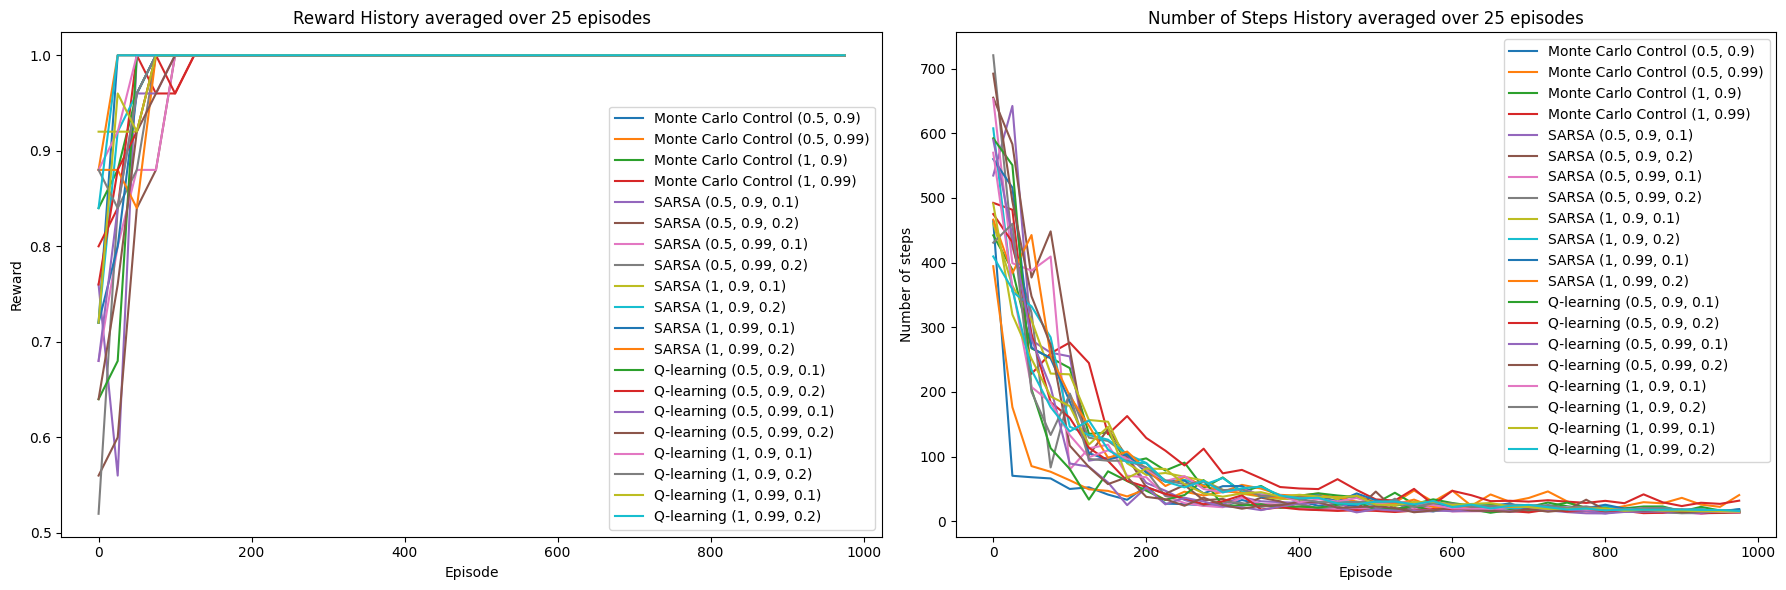

In [ ]:
# Display the reward and number of steps history for all policies of the empty environment in one plot
print("All Policies on Empty Environment")
plot_rewards_steps_comparison(policies=policy_dict_empty, policies_reward_history=reward_history_dict_empty, policies_num_steps_history=num_steps_history_dict_empty, amount_to_avg=25, figsize=(18, 6))

In [ ]:
# Display the reward and number of steps history for all policies of the empty environment in individual plots

display_individual_plots = False # Set to True/False to display individual plots

if display_individual_plots:
    amount_to_avg = 25
    print("\nMonte Carlo Control")
    display_reward_and_steps_dict(reward_history_dict_mc_empty, num_steps_history_dict_mc_empty, amount_to_avg=amount_to_avg)
    print("\nSARSA")
    display_reward_and_steps_dict(reward_history_dict_sarsa_empty, num_steps_history_dict_sarsa_empty, amount_to_avg=amount_to_avg)
    print("\nQ-learning")
    display_reward_and_steps_dict(reward_history_dict_q_learning_empty, num_steps_history_dict_q_learning_empty, amount_to_avg=amount_to_avg)

- choose the best hyperparameters for each algorithm

In [ ]:
# Get the best policy for each algorithm
best_policy_mc_empty, best_avg_reward_mc_empty, best_avg_steps_mc_empty, best_avg_done_mc_empty, best_key_mc_empty = get_best_policy_from_policy_dict(
    empty_env, policy_dict_mc_empty, num_episodes=100, max_steps=1000
)
best_policy_sarsa_empty, best_avg_reward_sarsa_empty, best_avg_steps_sarsa_empty, best_avg_done_sarsa_empty, best_key_sarsa_empty = get_best_policy_from_policy_dict(
    empty_env, policy_dict_sarsa_empty, num_episodes=100, max_steps=1000
)
best_policy_q_learning_empty, best_avg_reward_q_learning_empty, best_avg_steps_q_learning_empty, best_avg_done_q_learning_empty, best_key_q_learning_empty = get_best_policy_from_policy_dict(
    empty_env, policy_dict_q_learning_empty, num_episodes=100, max_steps=1000
)

# Print the best hyperparameters for each algorithm
print("Monte Carlo Control")
print(f"Best hyperparameters: {best_key_mc_empty} = (epsilon, gamma)")
print(f"Best average reward: {best_avg_reward_mc_empty}")
print(f"Best average number of steps: {best_avg_steps_mc_empty}")
print(f"Best average done: {best_avg_done_mc_empty}")
print("\nSARSA")
print(f"Best hyperparameters: {best_key_sarsa_empty} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_sarsa_empty}")
print(f"Best average number of steps: {best_avg_steps_sarsa_empty}")
print(f"Best average done: {best_avg_done_sarsa_empty}")
print("\nQ-learning")
print(f"Best hyperparameters: {best_key_q_learning_empty} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_q_learning_empty}")
print(f"Best average number of steps: {best_avg_steps_q_learning_empty}")
print(f"Best average done: {best_avg_done_q_learning_empty}")

Monte Carlo Control
Best hyperparameters: (1, 0.9) = (epsilon, gamma)
Best average reward: 0.99
Best average number of steps: 20.52
Best average done: 0.99

SARSA
Best hyperparameters: (1, 0.99, 0.1) = (epsilon, gamma, alpha)
Best average reward: 1.0
Best average number of steps: 9.18
Best average done: 1.0

Q-learning
Best hyperparameters: (1, 0.9, 0.1) = (epsilon, gamma, alpha)
Best average reward: 1.0
Best average number of steps: 9.37
Best average done: 1.0


- plot the rewards and steps for each algorithm best policy (in the same plot) for comparison

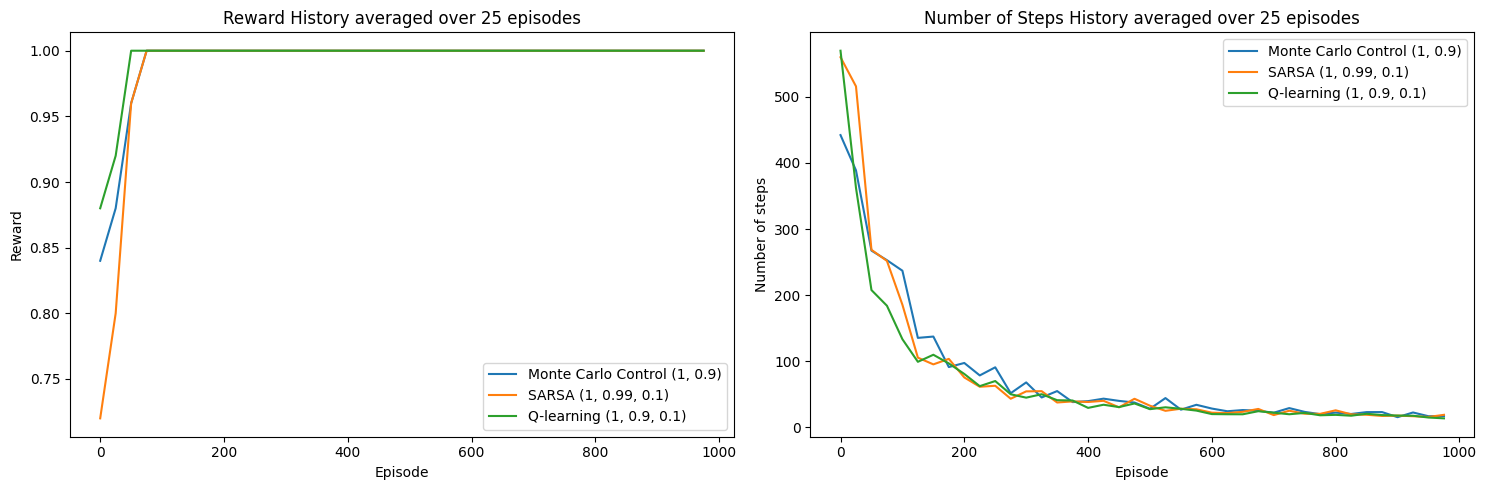

In [ ]:
# put the best policies in a dictionary with the algorithm name and best hyperparameters as the key and policy as the value
best_policies_empty = {
    ('Monte Carlo Control', best_key_mc_empty): best_policy_mc_empty,
    ('SARSA', best_key_sarsa_empty): best_policy_sarsa_empty,
    ('Q-learning', best_key_q_learning_empty): best_policy_q_learning_empty
}

best_policies_empty_reward_history = {
    ('Monte Carlo Control', best_key_mc_empty): reward_history_dict_mc_empty[best_key_mc_empty],
    ('SARSA', best_key_sarsa_empty): reward_history_dict_sarsa_empty[best_key_sarsa_empty],
    ('Q-learning', best_key_q_learning_empty): reward_history_dict_q_learning_empty[best_key_q_learning_empty]
}

best_policies_empty_num_steps_history = {
    ('Monte Carlo Control', best_key_mc_empty): num_steps_history_dict_mc_empty[best_key_mc_empty],
    ('SARSA', best_key_sarsa_empty): num_steps_history_dict_sarsa_empty[best_key_sarsa_empty],
    ('Q-learning', best_key_q_learning_empty): num_steps_history_dict_q_learning_empty[best_key_q_learning_empty]
}



# Plot the reward and number of steps history for the best policies in the same plot for comparison
plot_rewards_steps_comparison(best_policies_empty, best_policies_empty_reward_history, best_policies_empty_num_steps_history, amount_to_avg=25, figsize=(15, 5))


- show inference on the best policy for each algorithm

In [ ]:
# Show video of the best policy for MC Empty
video_filename_mc_empty = '/content/mc_empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_mc_empty, video_filename=video_filename_mc_empty)
print(f"Monte Carlo Control with Epsilon-Greedy policy: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_mc_empty)

Monte Carlo Control with Epsilon-Greedy policy: Done=True, Total Reward=1, Number of Steps=7


In [ ]:
# Show video of the best policy for SARSA Empty
video_filename_sarsa_empty = '/content/sarsa_empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_sarsa_empty, video_filename=video_filename_sarsa_empty)
print(f"SARSA: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_sarsa_empty)

SARSA: Done=True, Total Reward=1, Number of Steps=10


In [ ]:
# Show video of the best policy for Q-learning Empty
video_filename_q_learning_empty = '/content/q_learning_empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_q_learning_empty, video_filename=video_filename_q_learning_empty)
print(f"Q-learning: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_q_learning_empty)

Q-learning: Done=True, Total Reward=1, Number of Steps=14


- compare best policies for each algorithm and choose the best one

In [ ]:
# get the best policy from the dictionary
best_policy_empty, best_avg_reward_empty, best_avg_steps_empty, best_avg_done_empty, best_key_empty = get_best_policy_from_policy_dict(
    empty_env, best_policies_empty, num_episodes=500, max_steps=1000
)

# Print the best hyperparameters for the best policy
print("Best Policy for Empty Environment")
print(f"Best hyperparameters: {best_key_empty} = (algorithm, (epsilon, gamma, alpha))")
print(f"Best average reward: {best_avg_reward_empty}")
print(f"Best average number of steps: {best_avg_steps_empty}")
print(f"Best average done: {best_avg_done_empty}")


Best Policy for Empty Environment
Best hyperparameters: ('SARSA', (1, 0.99, 0.1)) = (algorithm, (epsilon, gamma, alpha))
Best average reward: 1.0
Best average number of steps: 9.594
Best average done: 1.0


## Performe grid search on Key Environment

- define hyperparameters
- perform grid search on key environment for each algorithm
- plot the results
- choose the best hyperparameters for each algorithm
- show inference on the best policy for each algorithm
- compare best policies for each algorithm and choose the best one

- define hyperparameters

In [ ]:
# Define hyperparameters for MC, SARSA and Q-learning grid search
num_episodes = 3000
max_steps = 5000
epsilons = [0.5, 1]
gammas = [0.9, 0.99]
alphas = [0.1, 0.2]
epsilon_decay = 0.999
avoid_actions = [4,6]
reward_shaping = True
print_every = int(num_episodes / 2)

# Initialize the environment
key_env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))

- perform grid search on key environment for each algorithm

In [ ]:
# Perform the grid search for MC on the empty environment
print("Monte Carlo Control")
policy_dict_mc_key, Q_dict_mc_key, reward_history_dict_mc_key, num_steps_history_dict_mc_key = grid_search_mc(
    key_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=avoid_actions,
    reward_shaping=True
)

# Perform the grid search for SARSA on the empty environment
print("\nSARSA")
policy_dict_sarsa_key, Q_dict_sarsa_key, reward_history_dict_sarsa_key, num_steps_history_dict_sarsa_key = grid_search_TD(
    key_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='sarsa',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=avoid_actions,
    reward_shaping=True
)

# Perform the grid search for Q-learning on the empty environment
print("\nQ-learning")
policy_dict_q_learning_key, Q_dict_q_learning_key, reward_history_dict_q_learning_key, num_steps_history_dict_q_learning_key = grid_search_TD(
    key_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='q_learning',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=avoid_actions,
    reward_shaping=True
)

Monte Carlo Control
Training for epsilon=0.5, gamma=0.9


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.000, Avg reward: 0.000, Avg steps: 5000.000, epsilon: 0.500

 50%|████▉     | 1498/3000 [05:57<01:52, 13.34it/s]

Episode 1500/3000. avg done: 0.990, Avg reward: 0.991, Avg steps: 293.138, epsilon: 0.111

100%|█████████▉| 2993/3000 [07:07<00:00, 51.28it/s]

Episode 2999/3000. avg done: 0.998, Avg reward: 0.999, Avg steps: 67.411, epsilon: 0.025

100%|██████████| 3000/3000 [07:07<00:00,  7.01it/s]



Done training for epsilon=0.5, gamma=0.9

Training for epsilon=0.5, gamma=0.99


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.000, Avg steps: 482.000, epsilon: 0.500

 50%|████▉     | 1499/3000 [08:25<06:21,  3.93it/s]

Episode 1500/3000. avg done: 0.991, Avg reward: 0.992, Avg steps: 439.781, epsilon: 0.111

100%|█████████▉| 2999/3000 [11:58<00:00, 13.15it/s]

Episode 2999/3000. avg done: 0.997, Avg reward: 0.998, Avg steps: 209.024, epsilon: 0.025

100%|██████████| 3000/3000 [11:58<00:00,  4.17it/s]



Done training for epsilon=0.5, gamma=0.99

Training for epsilon=1, gamma=0.9


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 1556.000, epsilon: 1.000

 50%|████▉     | 1498/3000 [06:50<01:21, 18.53it/s]

Episode 1500/3000. avg done: 0.997, Avg reward: 0.998, Avg steps: 351.271, epsilon: 0.223

100%|█████████▉| 2994/3000 [08:00<00:00, 54.47it/s]

Episode 2999/3000. avg done: 0.999, Avg reward: 1.000, Avg steps: 70.165, epsilon: 0.050

100%|██████████| 3000/3000 [08:00<00:00,  6.24it/s]



Done training for epsilon=1, gamma=0.9

Training for epsilon=1, gamma=0.99


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 4061.000, epsilon: 1.000

 50%|█████     | 1500/3000 [09:38<08:46,  2.85it/s]

Episode 1500/3000. avg done: 0.997, Avg reward: 0.998, Avg steps: 513.281, epsilon: 0.223

100%|█████████▉| 2999/3000 [13:48<00:00,  5.16it/s]

Episode 2999/3000. avg done: 0.999, Avg reward: 1.000, Avg steps: 251.669, epsilon: 0.050

100%|██████████| 3000/3000 [13:48<00:00,  3.62it/s]



Done training for epsilon=1, gamma=0.99


SARSA
Training for epsilon=0.5, gamma=0.9, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.000, Avg steps: 4747.000, epsilon: 0.500

 50%|█████     | 1500/3000 [12:19<08:08,  3.07it/s]

Episode 1500/3000. avg done: 0.972, Avg reward: 0.973, Avg steps: 865.373, epsilon: 0.111

100%|█████████▉| 2993/3000 [14:59<00:00, 38.67it/s]

Episode 2999/3000. avg done: 0.990, Avg reward: 0.991, Avg steps: 192.289, epsilon: 0.025

100%|██████████| 3000/3000 [14:59<00:00,  3.34it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.1

Training for epsilon=0.5, gamma=0.9, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 3155.000, epsilon: 0.500

 50%|████▉     | 1497/3000 [12:57<06:25,  3.90it/s]

Episode 1500/3000. avg done: 0.966, Avg reward: 0.967, Avg steps: 909.598, epsilon: 0.111

100%|█████████▉| 2993/3000 [16:22<00:02,  3.25it/s]

Episode 2999/3000. avg done: 0.987, Avg reward: 0.988, Avg steps: 247.055, epsilon: 0.025

100%|██████████| 3000/3000 [16:22<00:00,  3.05it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.2

Training for epsilon=0.5, gamma=0.99, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 4316.000, epsilon: 0.500

 50%|████▉     | 1494/3000 [12:51<09:09,  2.74it/s]

Episode 1500/3000. avg done: 0.973, Avg reward: 0.974, Avg steps: 901.575, epsilon: 0.111

100%|█████████▉| 2995/3000 [15:51<00:00, 11.11it/s]

Episode 2999/3000. avg done: 0.993, Avg reward: 0.994, Avg steps: 216.086, epsilon: 0.025

100%|██████████| 3000/3000 [15:51<00:00,  3.15it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.1

Training for epsilon=0.5, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 2089.000, epsilon: 0.500

 50%|████▉     | 1499/3000 [11:58<03:51,  6.49it/s]

Episode 1500/3000. avg done: 0.972, Avg reward: 0.973, Avg steps: 838.207, epsilon: 0.111

100%|█████████▉| 2999/3000 [13:46<00:00, 26.49it/s]

Episode 2999/3000. avg done: 0.998, Avg reward: 0.999, Avg steps: 126.543, epsilon: 0.025

100%|██████████| 3000/3000 [13:46<00:00,  3.63it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.2

Training for epsilon=1, gamma=0.9, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 649.000, epsilon: 1.000

 50%|████▉     | 1499/3000 [10:42<02:51,  8.75it/s]

Episode 1500/3000. avg done: 0.991, Avg reward: 0.992, Avg steps: 728.991, epsilon: 0.223

100%|█████████▉| 2997/3000 [12:12<00:00, 65.07it/s]

Episode 2999/3000. avg done: 0.999, Avg reward: 1.000, Avg steps: 106.711, epsilon: 0.050

100%|██████████| 3000/3000 [12:13<00:00,  4.09it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.1

Training for epsilon=1, gamma=0.9, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 3721.000, epsilon: 1.000

 50%|████▉     | 1499/3000 [09:42<01:15, 19.99it/s]

Episode 1500/3000. avg done: 0.988, Avg reward: 0.989, Avg steps: 661.809, epsilon: 0.223

100%|█████████▉| 2999/3000 [11:21<00:00, 10.07it/s]

Episode 2999/3000. avg done: 0.998, Avg reward: 0.999, Avg steps: 116.553, epsilon: 0.050

100%|██████████| 3000/3000 [11:21<00:00,  4.40it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.2

Training for epsilon=1, gamma=0.99, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.000, Avg steps: 3066.000, epsilon: 1.000

 50%|█████     | 1500/3000 [10:23<01:51, 13.46it/s]

Episode 1500/3000. avg done: 0.990, Avg reward: 0.991, Avg steps: 706.071, epsilon: 0.223

100%|█████████▉| 2994/3000 [12:03<00:00, 29.31it/s]

Episode 2999/3000. avg done: 0.999, Avg reward: 1.000, Avg steps: 119.241, epsilon: 0.050

100%|██████████| 3000/3000 [12:04<00:00,  4.14it/s]



Done training for epsilon=1, gamma=0.99, alpha=0.1

Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.000, Avg reward: 0.000, Avg steps: 4999.000, epsilon: 1.000

 50%|████▉     | 1499/3000 [08:48<01:37, 15.39it/s]

Episode 1500/3000. avg done: 0.993, Avg reward: 0.994, Avg steps: 601.792, epsilon: 0.223

100%|█████████▉| 2997/3000 [10:31<00:00, 27.36it/s]

Episode 2999/3000. avg done: 0.998, Avg reward: 0.999, Avg steps: 120.573, epsilon: 0.050

100%|██████████| 3000/3000 [10:32<00:00,  4.75it/s]



Done training for epsilon=1, gamma=0.99, alpha=0.2


Q-learning
Training for epsilon=0.5, gamma=0.9, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.000, Avg reward: 0.001, Avg steps: 4999.000, epsilon: 0.500

 50%|████▉     | 1498/3000 [12:59<04:48,  5.20it/s]

Episode 1500/3000. avg done: 0.945, Avg reward: 0.946, Avg steps: 891.885, epsilon: 0.111

100%|█████████▉| 2995/3000 [15:08<00:00, 52.97it/s]

Episode 2999/3000. avg done: 0.993, Avg reward: 0.994, Avg steps: 149.129, epsilon: 0.025

100%|██████████| 3000/3000 [15:08<00:00,  3.30it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.1

Training for epsilon=0.5, gamma=0.9, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 1030.000, epsilon: 0.500

 50%|████▉     | 1497/3000 [12:00<01:21, 18.53it/s]

Episode 1500/3000. avg done: 0.959, Avg reward: 0.960, Avg steps: 820.543, epsilon: 0.111

100%|█████████▉| 2994/3000 [13:29<00:00, 43.53it/s]

Episode 2999/3000. avg done: 0.995, Avg reward: 0.996, Avg steps: 102.032, epsilon: 0.025

100%|██████████| 3000/3000 [13:29<00:00,  3.70it/s]



Done training for epsilon=0.5, gamma=0.9, alpha=0.2

Training for epsilon=0.5, gamma=0.99, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.000, Avg reward: 0.001, Avg steps: 4999.000, epsilon: 0.500

 50%|████▉     | 1497/3000 [13:05<02:47,  8.99it/s]

Episode 1500/3000. avg done: 0.954, Avg reward: 0.955, Avg steps: 895.241, epsilon: 0.111

100%|█████████▉| 2999/3000 [14:45<00:00, 48.39it/s]

Episode 2999/3000. avg done: 0.999, Avg reward: 1.000, Avg steps: 112.922, epsilon: 0.025

100%|██████████| 3000/3000 [14:45<00:00,  3.39it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.1

Training for epsilon=0.5, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.000, Avg reward: 0.001, Avg steps: 4999.000, epsilon: 0.500

 50%|████▉     | 1498/3000 [11:46<04:34,  5.48it/s]

Episode 1500/3000. avg done: 0.957, Avg reward: 0.958, Avg steps: 802.759, epsilon: 0.111

100%|█████████▉| 2995/3000 [13:25<00:00, 60.90it/s]

Episode 2999/3000. avg done: 0.997, Avg reward: 0.998, Avg steps: 114.734, epsilon: 0.025

100%|██████████| 3000/3000 [13:25<00:00,  3.72it/s]



Done training for epsilon=0.5, gamma=0.99, alpha=0.2

Training for epsilon=1, gamma=0.9, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 1272.000, epsilon: 1.000

 50%|████▉     | 1499/3000 [05:46<00:49, 30.56it/s]

Episode 1500/3000. avg done: 0.993, Avg reward: 0.994, Avg steps: 380.386, epsilon: 0.223

100%|█████████▉| 2997/3000 [06:23<00:00, 73.01it/s]

Episode 2999/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 41.591, epsilon: 0.050

100%|██████████| 3000/3000 [06:23<00:00,  7.82it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.1

Training for epsilon=1, gamma=0.9, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 3163.000, epsilon: 1.000

 50%|█████     | 1500/3000 [05:31<04:28,  5.59it/s]

Episode 1500/3000. avg done: 0.994, Avg reward: 0.995, Avg steps: 364.507, epsilon: 0.223

100%|█████████▉| 2996/3000 [06:12<00:00, 54.54it/s]

Episode 2999/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 45.770, epsilon: 0.050

100%|██████████| 3000/3000 [06:12<00:00,  8.05it/s]



Done training for epsilon=1, gamma=0.9, alpha=0.2

Training for epsilon=1, gamma=0.99, alpha=0.1


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.000, Avg reward: 0.001, Avg steps: 4999.000, epsilon: 1.000

 50%|████▉     | 1499/3000 [05:21<01:31, 16.42it/s]

Episode 1500/3000. avg done: 0.996, Avg reward: 0.997, Avg steps: 350.441, epsilon: 0.223

100%|█████████▉| 2995/3000 [05:53<00:00, 71.88it/s]

Episode 2999/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 36.811, epsilon: 0.050

100%|██████████| 3000/3000 [05:54<00:00,  8.47it/s]



Done training for epsilon=1, gamma=0.99, alpha=0.1

Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.000, Avg reward: 0.001, Avg steps: 4999.000, epsilon: 1.000

 50%|█████     | 1500/3000 [05:02<00:30, 49.48it/s]

Episode 1500/3000. avg done: 0.995, Avg reward: 0.996, Avg steps: 334.089, epsilon: 0.223

100%|█████████▉| 2991/3000 [05:59<00:00, 62.08it/s]

Episode 2999/3000. avg done: 1.000, Avg reward: 1.001, Avg steps: 64.546, epsilon: 0.050

100%|██████████| 3000/3000 [05:59<00:00,  8.34it/s]


Done training for epsilon=1, gamma=0.99, alpha=0.2



- plot the results

Monte Carlo on Key Env


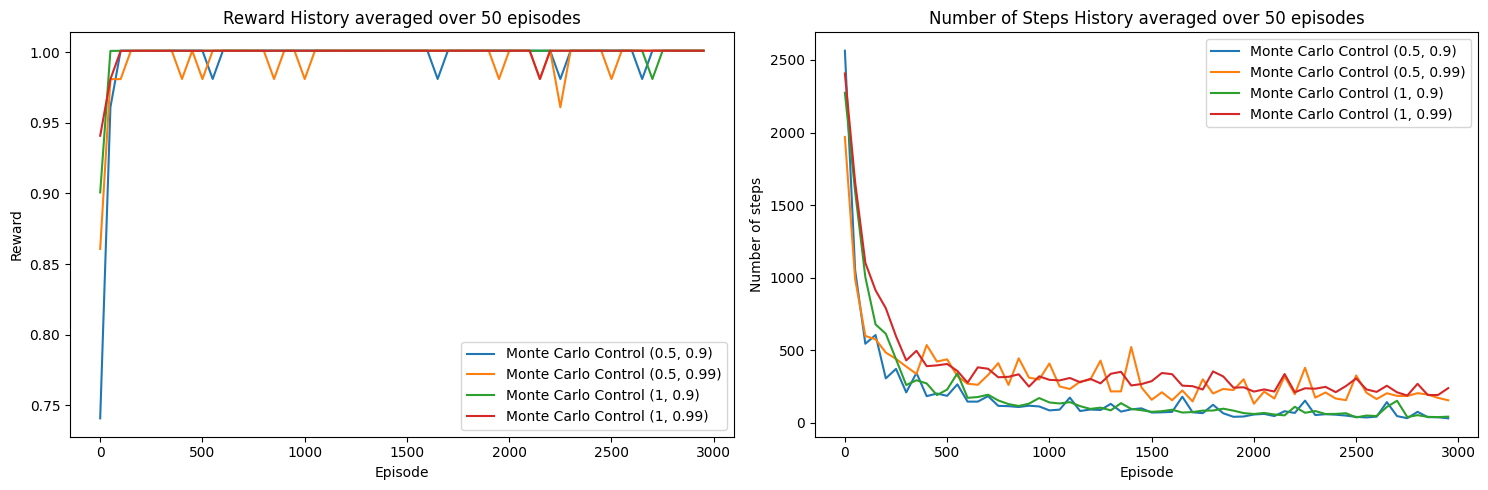


SARSA on Key Env


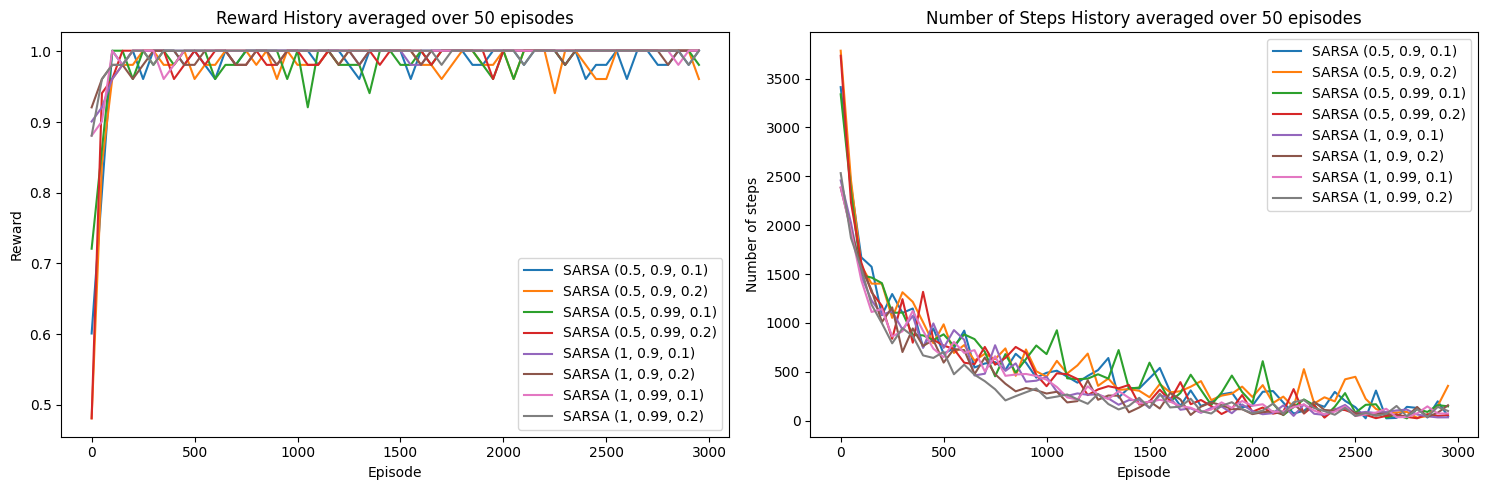


Q-learning on Key Env


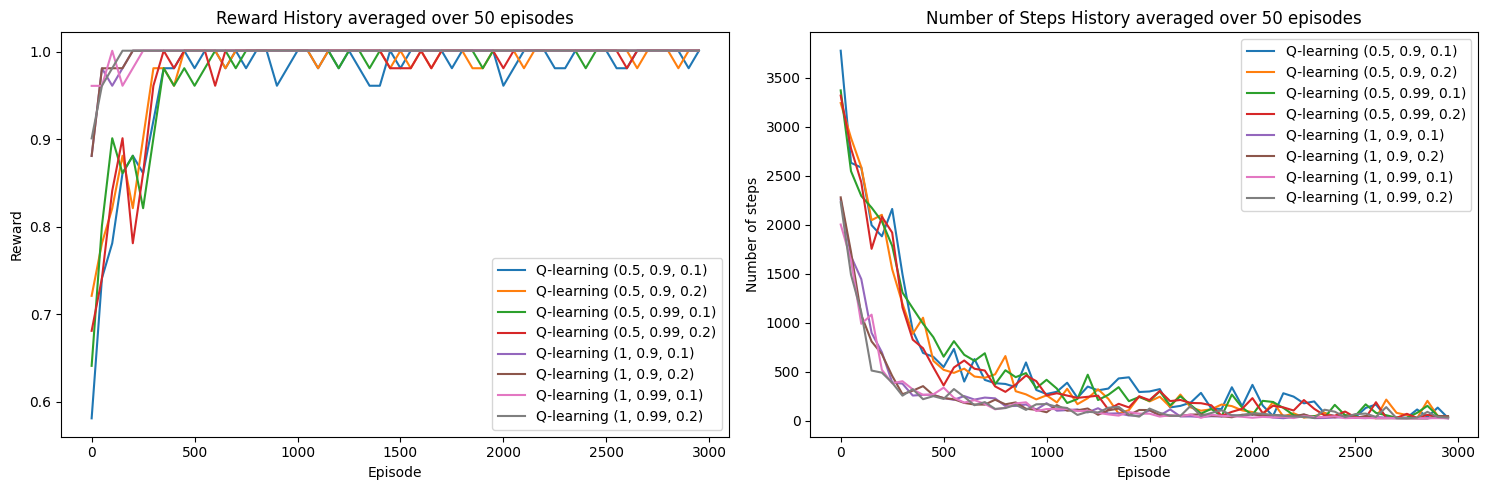

In [ ]:
# Plot for each algo the reward and number of steps history for each hyperparameter set for the key environment
algo_mc_dict_key = {('Monte Carlo Control', key): value for key, value in policy_dict_mc_key.items()}
algo_sarsa_dict_key = {('SARSA', key): value for key, value in policy_dict_sarsa_key.items()}
algo_q_learning_dict_key = {('Q-learning', key): value for key, value in policy_dict_q_learning_key.items()}

algo_mc_reward_history_dict_key = {('Monte Carlo Control', key): value for key, value in reward_history_dict_mc_key.items()}
algo_sarsa_reward_history_dict_key = {('SARSA', key): value for key, value in reward_history_dict_sarsa_key.items()}
algo_q_learning_reward_history_dict_key = {('Q-learning', key): value for key, value in reward_history_dict_q_learning_key.items()}

algo_mc_num_steps_history_dict_key = {('Monte Carlo Control', key): value for key, value in num_steps_history_dict_mc_key.items()}
algo_sarsa_num_steps_history_dict_key = {('SARSA', key): value for key, value in num_steps_history_dict_sarsa_key.items()}
algo_q_learning_num_steps_history_dict_key = {('Q-learning', key): value for key, value in num_steps_history_dict_q_learning_key.items()}

figsize = (15, 5)
amount_to_avg = 50
print("Monte Carlo on Key Env")
plot_rewards_steps_comparison(policies=algo_mc_dict_key, policies_reward_history=algo_mc_reward_history_dict_key, policies_num_steps_history=algo_mc_num_steps_history_dict_key, amount_to_avg=amount_to_avg, figsize=figsize)

print("\nSARSA on Key Env")
plot_rewards_steps_comparison(policies=algo_sarsa_dict_key, policies_reward_history=algo_sarsa_reward_history_dict_key, policies_num_steps_history=algo_sarsa_num_steps_history_dict_key, amount_to_avg=amount_to_avg, figsize=figsize)

print("\nQ-learning on Key Env")
plot_rewards_steps_comparison(policies=algo_q_learning_dict_key, policies_reward_history=algo_q_learning_reward_history_dict_key, policies_num_steps_history=algo_q_learning_num_steps_history_dict_key, amount_to_avg=amount_to_avg, figsize=figsize)


In [ ]:
# put all the policies in one dictionary
policy_dict_key = algo_mc_dict_key.copy()
policy_dict_key.update(algo_sarsa_dict_key)
policy_dict_key.update(algo_q_learning_dict_key)

# put all the rewards in one dictionary
reward_history_dict_key = algo_mc_reward_history_dict_key.copy()
reward_history_dict_key.update(algo_sarsa_reward_history_dict_key)
reward_history_dict_key.update(algo_q_learning_reward_history_dict_key)

# put all the number of steps in one dictionary
num_steps_history_dict_key = algo_mc_num_steps_history_dict_key.copy()
num_steps_history_dict_key.update(algo_sarsa_num_steps_history_dict_key)
num_steps_history_dict_key.update(algo_q_learning_num_steps_history_dict_key)

All Policies on Key Environment


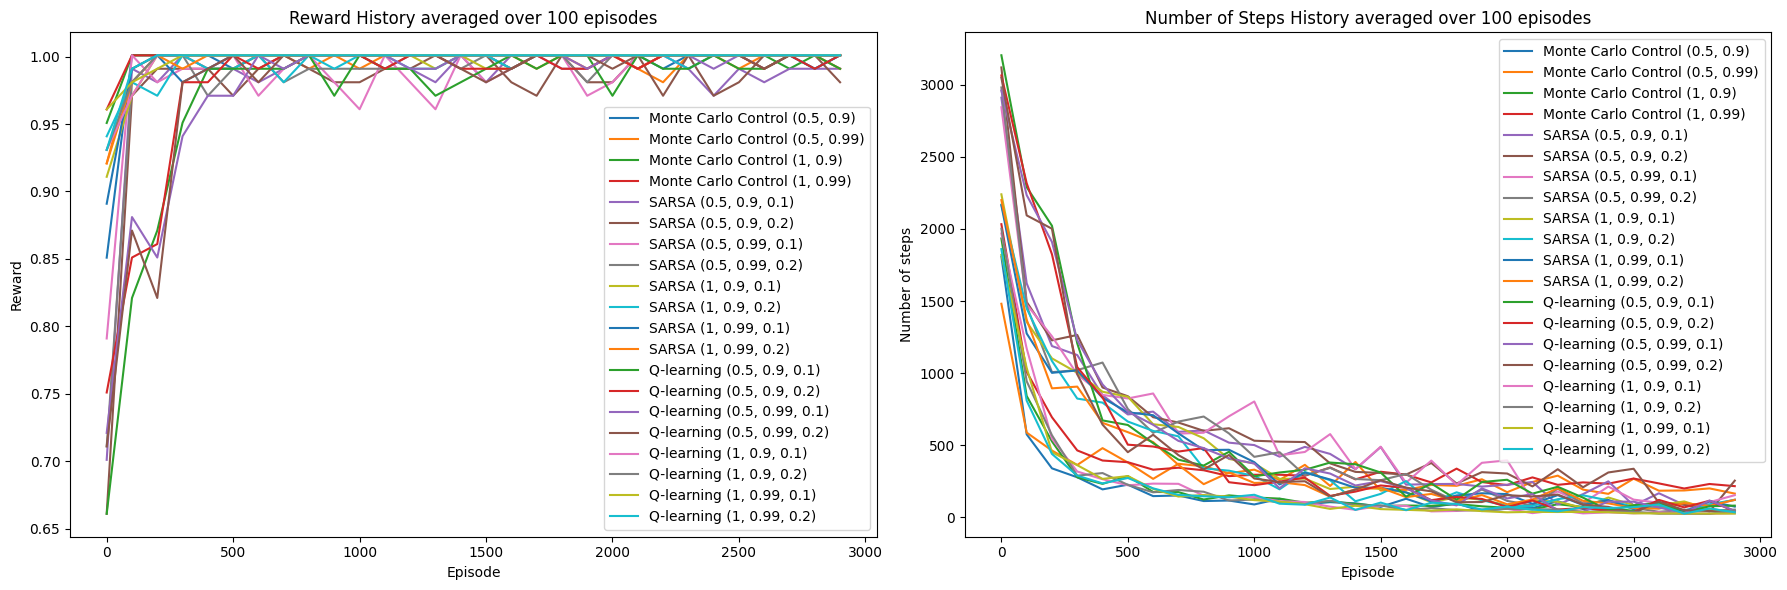

In [ ]:
# Display the reward and number of steps history for all policies of the empty environment in one plot
print("All Policies on Key Environment")
plot_rewards_steps_comparison(policies=policy_dict_key, policies_reward_history=reward_history_dict_key, policies_num_steps_history=num_steps_history_dict_key, amount_to_avg=100, figsize=(18, 6))


In [ ]:
# Display the reward and number of steps history for all policies of the key environment in individual plots

display_individual_plots = False # Set to True/False to display individual plots

if display_individual_plots:
    amount_to_avg = 25
    print("Monte Carlo Control")
    display_reward_and_steps_dict(reward_history_dict_mc_key, num_steps_history_dict_mc_key, amount_to_avg=amount_to_avg)
    print("\nSARSA")
    display_reward_and_steps_dict(reward_history_dict_sarsa_key, num_steps_history_dict_sarsa_key, amount_to_avg=amount_to_avg)
    print("\nQ-learning")
    display_reward_and_steps_dict(reward_history_dict_q_learning_key, num_steps_history_dict_q_learning_key, amount_to_avg=amount_to_avg)

- choose the best hyperparameters for each algorithm

In [ ]:
# Get the best policy for each algorithm
best_policy_mc_key, best_avg_reward_mc_key, best_avg_steps_mc_key, best_avg_done_mc_key, best_key_mc_key = get_best_policy_from_policy_dict(
    key_env, policy_dict_mc_key, num_episodes=100, max_steps=1000
)
best_policy_sarsa_key, best_avg_reward_sarsa_key, best_avg_steps_sarsa_key, best_avg_done_sarsa_key, best_key_sarsa_key = get_best_policy_from_policy_dict(
    key_env, policy_dict_sarsa_key, num_episodes=100, max_steps=1000
)
best_policy_q_learning_key, best_avg_reward_q_learning_key, best_avg_steps_q_learning_key, best_avg_done_q_learning_key, best_key_q_learning_key = get_best_policy_from_policy_dict(
    key_env, policy_dict_q_learning_key, num_episodes=100, max_steps=1000
)

# Print the best hyperparameters for each algorithm
print("Monte Carlo Control")
print(f"Best hyperparameters: {best_key_mc_key} = (epsilon, gamma)")
print(f"Best average reward: {best_avg_reward_mc_key}")
print(f"Best average number of steps: {best_avg_steps_mc_key}")
print(f"Best average done: {best_avg_done_mc_key}")
print("\nSARSA")
print(f"Best hyperparameters: {best_key_sarsa_key} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_sarsa_key}")
print(f"Best average number of steps: {best_avg_steps_sarsa_key}")
print(f"Best average done: {best_avg_done_sarsa_key}")
print("\nQ-learning")
print(f"Best hyperparameters: {best_key_q_learning_key} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_q_learning_key}")
print(f"Best average number of steps: {best_avg_steps_q_learning_key}")
print(f"Best average done: {best_avg_done_q_learning_key}")

Monte Carlo Control
Best hyperparameters: (0.5, 0.9) = (epsilon, gamma)
Best average reward: 0.98
Best average number of steps: 46.3
Best average done: 0.98

SARSA
Best hyperparameters: (1, 0.99, 0.2) = (epsilon, gamma, alpha)
Best average reward: 0.99
Best average number of steps: 32.3
Best average done: 0.99

Q-learning
Best hyperparameters: (1, 0.9, 0.1) = (epsilon, gamma, alpha)
Best average reward: 1.0
Best average number of steps: 22.85
Best average done: 1.0


- plot the rewards and steps for each algorithm best policy (in the same plot) for comparison


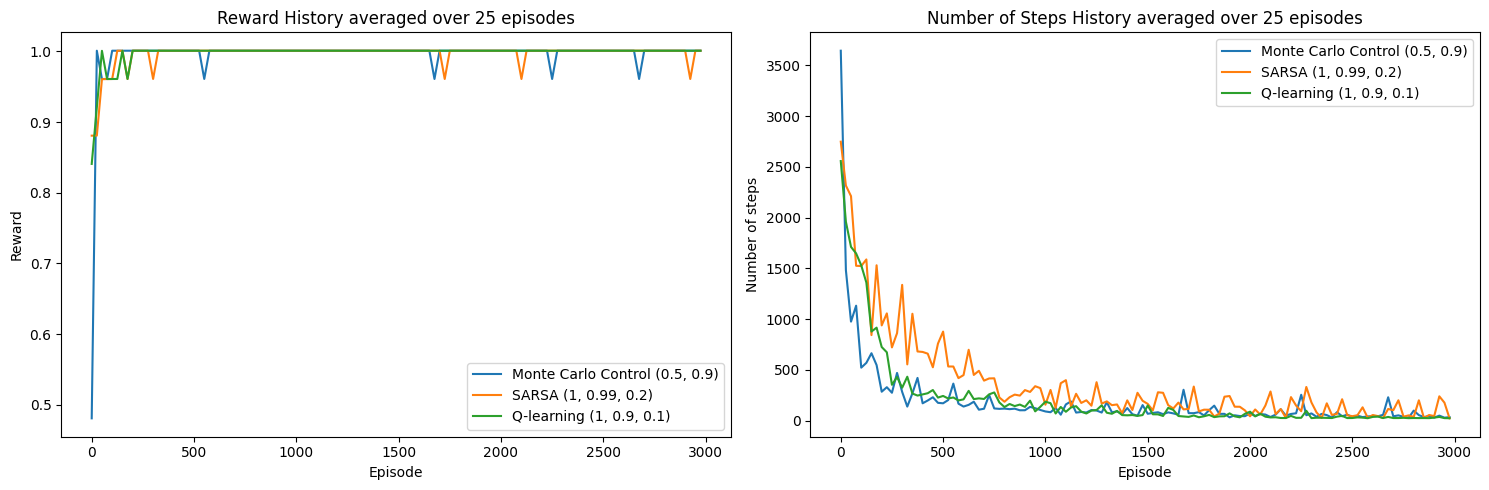

In [ ]:
# put the best policies in a dictionary with the algorithm name and best hyperparameters as the key and policy as the value
best_policies_key = {
    ('Monte Carlo Control', best_key_mc_key): best_policy_mc_key,
    ('SARSA', best_key_sarsa_key): best_policy_sarsa_key,
    ('Q-learning', best_key_q_learning_key): best_policy_q_learning_key
}

best_policies_key_reward_history = {
    ('Monte Carlo Control', best_key_mc_key): reward_history_dict_mc_key[best_key_mc_key],
    ('SARSA', best_key_sarsa_key): reward_history_dict_sarsa_key[best_key_sarsa_key],
    ('Q-learning', best_key_q_learning_key): reward_history_dict_q_learning_key[best_key_q_learning_key]
}

best_policies_key_num_steps_history = {
    ('Monte Carlo Control', best_key_mc_key): num_steps_history_dict_mc_key[best_key_mc_key],
    ('SARSA', best_key_sarsa_key): num_steps_history_dict_sarsa_key[best_key_sarsa_key],
    ('Q-learning', best_key_q_learning_key): num_steps_history_dict_q_learning_key[best_key_q_learning_key]
}

# Plot the reward and number of steps history for the best policies in the same plot for comparison
plot_rewards_steps_comparison(best_policies_key, best_policies_key_reward_history, best_policies_key_num_steps_history, amount_to_avg=25, figsize=(15, 5))


- show inference on the best policy for each algorithm

In [ ]:
# Show video example of the best MC key policy
video_filename_mc_key = '/content/mc_key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_mc_key, video_filename=video_filename_mc_key)
print(f"Monte Carlo Control with Epsilon-Greedy policy: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_mc_key)

Monte Carlo Control with Epsilon-Greedy policy: Done=True, Total Reward=1, Number of Steps=27


In [ ]:
# Show video example of the best SARSA key policy
video_filename_sarsa_key = '/content/sarsa_key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_sarsa_key, video_filename=video_filename_sarsa_key)
print(f"SARSA: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_sarsa_key)

SARSA: Done=True, Total Reward=1, Number of Steps=24


In [ ]:
# Show video example of the best Q-learning key policy
video_filename_q_learning_key = '/content/q_learning_key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_q_learning_key, video_filename=video_filename_q_learning_key)
print(f"Q-learning: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_q_learning_key)

Q-learning: Done=True, Total Reward=1, Number of Steps=21


- compare best policies for each algorithm and choose the best one

In [ ]:
# get the best policy from the dictionary
best_policy_key, best_avg_reward_key, best_avg_steps_key, best_avg_done_key, best_key_key = get_best_policy_from_policy_dict(
    key_env, best_policies_key, num_episodes=500, max_steps=1000
)

# Print the best hyperparameters for the best policy
print("Best Policy for Key Environment")
print(f"Best hyperparameters: {best_key_key} = (algorithm, (epsilon, gamma, alpha))")
print(f"Best average reward: {best_avg_reward_key}")
print(f"Best average number of steps: {best_avg_steps_key}")
print(f"Best average done: {best_avg_done_key}")

Best Policy for Key Environment
Best hyperparameters: ('Q-learning', (1, 0.9, 0.1)) = (algorithm, (epsilon, gamma, alpha))
Best average reward: 1.0
Best average number of steps: 23.448
Best average done: 1.0


## Best Policy for each Environment
- Summarizing the Best Policy Outcomes for Different Environments
- Evaluating and Reporting on Best Policies in Practice
- Inference on the best policy for each Environment and show video of the agent in action

### Summarizing the Best Policy Outcomes for Different Environments

This section highlights the process of presenting the optimal policies discovered through reinforcement learning algorithms for different environment setups. Specifically, it focuses on summarizing the outcomes for "Empty Environment" and "Key Environment," showcasing how the best hyperparameters and their corresponding performance metrics are identified and reported.

- **Best Policy for Empty Environment:**
    - **Hyperparameters:** Demonstrates the best combination of algorithm and parameters (initial epsilon, gamma, and alpha) that resulted in the most effective learning for an environment devoid of obstacles or challenges.
    - **Performance Metrics:** Shares insights into the training phase, including the best average reward, the average number of steps taken, and the completion rate (done flag) across episodes.

- **Best Policy for Key Environment:**
    - Moves on to a more complex scenario where the agent must navigate to find a key and unlock a door before reaching the goal.
    - Similarly reports on the optimal settings and outcomes, focusing on how well the chosen policy adapts to the additional complexity introduced by the need to interact with an object within the environment.

This concise reporting allows for a clear understanding of the effectiveness of different reinforcement learning strategies and their applicability to varying types of challenges within simulated environments.

In [ ]:
# print best policie for empty env
print("Best Policy for Empty Environment")
print(f"Best hyperparameters: {best_key_empty} = (algorithm, (init_epsilon, gamma, alpha) )")
print(f"Best average reward training: {best_avg_reward_empty}")
print(f"Best average number of steps training: {best_avg_steps_empty}")
print(f"Best average done training: {best_avg_done_empty}")

# print best policie for key env
print("\nBest Policy for Key Environment")
print(f"Best hyperparameters: {best_key_key} = (algorithm, (init_epsilon, gamma, alpha) )")
print(f"Best average reward training: {best_avg_reward_key}")
print(f"Best average number of steps training: {best_avg_steps_key}")
print(f"Best average done training: {best_avg_done_key}")


Best Policy for Empty Environment
Best hyperparameters: ('SARSA', (1, 0.99, 0.1)) = (algorithm, (init_epsilon, gamma, alpha) )
Best average reward training: 1.0
Best average number of steps training: 9.594
Best average done training: 1.0

Best Policy for Key Environment
Best hyperparameters: ('Q-learning', (1, 0.9, 0.1)) = (algorithm, (init_epsilon, gamma, alpha) )
Best average reward training: 1.0
Best average number of steps training: 23.448
Best average done training: 1.0


### Evaluating and Reporting on Best Policies in Practice

Following the identification of the best policies for different environments, this section delves into their practical evaluation. It systematically assesses how these policies perform in new, unseen episodes, providing a quantitative measure of their effectiveness in real-world application scenarios.

- **Evaluation of the Best Policy for Empty Environment:**
    - Conducts a thorough test of the policy deemed most effective for the empty environment, using a set number of episodes to measure its average reward, steps taken, and completion success rate.
    - Offers a detailed look at how the policy generalizes to new instances of the environment, underlining its reliability and efficiency.

- **Evaluation of the Best Policy for Key Environment:**
    - Applies the same rigorous evaluation to the policy optimized for the key environment, again focusing on reward, step efficiency, and the rate of task completion.
    - Highlights the adaptability of the policy to scenarios that require interaction with objects to achieve the goal, emphasizing its practical utility.

By providing a structured evaluation of these policies, the approach underscores the importance of thorough testing in reinforcement learning, ensuring that the derived strategies are not only theoretically sound but also practically viable.

In [ ]:
# evaluate the best policy for the empty environment and print the results
avg_reward_empty, avg_steps_empty, avg_done_empty = evaluate_policy(empty_env, best_policy_empty, num_episodes=100, max_steps=1000)
print("\nEvaluation of the Best Policy for Empty Environment")
print(f"Average Reward Inference: {avg_reward_empty}")
print(f"Average Number of Steps Inference: {avg_steps_empty}")
print(f"Average Done Inference: {avg_done_empty}")

# evaluate the best policy for the key environment and print the results
avg_reward_key, avg_steps_key, avg_done_key = evaluate_policy(key_env, best_policy_key, num_episodes=100, max_steps=1000)
print("\nEvaluation of the Best Policy for Key Environment")
print(f"Average Reward Inference: {avg_reward_key}")
print(f"Average Number of Steps Inference: {avg_steps_key}")
print(f"Average Done Inference: {avg_done_key}")


Evaluation of the Best Policy for Empty Environment
Average Reward Inference: 1.0
Average Number of Steps Inference: 9.22
Average Done Inference: 1.0

Evaluation of the Best Policy for Key Environment
Average Reward Inference: 1.0
Average Number of Steps Inference: 23.23
Average Done Inference: 1.0


### Inference on the best policy for each Environment and show video of the agent in action

In [ ]:
# show video of the best policy for the empty environment
video_filename_empty = '/content/empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_empty, video_filename=video_filename_empty)
print(f"Empty Environment: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_empty)

Empty Environment: Done=True, Total Reward=1, Number of Steps=7


In [ ]:
# show video of the best policy for the key environment
video_filename_key = '/content/key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_key, video_filename=video_filename_key)
print(f"Key Environment: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_key)

Key Environment: Done=True, Total Reward=1, Number of Steps=20
